# Trend Forecasting using Prophet 

In [110]:
import matplotlib
import matplotlib.pyplot as plt
import warnings

# Ignore UserWarnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [33]:
warnings.filterwarnings('ignore')

In [ ]:
# Driver code
# Import the NeuralProphet class
from neuralprophet import NeuralProphet, set_log_level
# Disable logging messages unless there is an error
set_log_level("ERROR")




In [34]:
#Imports
# General Import
import pandas as pd
import numpy as np 

# Local Import
import sys
package_path = '/home/Lakehouse/DreamBrookPy/src'
if package_path not in sys.path:
    sys.path.append(package_path)
import DreamBrookPy.MachineLearning as ML
import DreamBrookPy.DataChef as DC

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
# settings for plotting
# Figure properties\
tick_width = 2
tick_length = 8
matplotlib.rcParams['axes.linewidth'] = 2.5
matplotlib.rcParams['savefig.transparent'] = False
matplotlib.rcParams['figure.autolayout'] = False
matplotlib.rcParams['figure.constrained_layout.use'] = False
matplotlib.rcParams['axes.unicode_minus'] = False # using small minus sign (i.e. hypen-minus) and not the default unicode minus
matplotlib.rcParams["font.weight"] = "bold"
matplotlib.rcParams["axes.labelweight"] = "bold"
matplotlib.rcParams["axes.linewidth"] = 2.0
matplotlib.rcParams["axes.labelsize"] = 20
matplotlib.rcParams['savefig.dpi'] = 300

In [ ]:
# Load Data for Google Trend

In [35]:
filepath = '/home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/combined_df_dict.pkl'
combined_df_dict = DC.load_dict(filepath)

In [37]:
namelist = combined_df_dict.keys()

In [48]:
c ='polkadot'
mytrend = combined_df_dict[c][['Start_Date','count']]
myprice = combined_df_dict[c][['Start_Date','count','Close_Ave']]
myvolume = combined_df_dict[c][['Start_Date','count','Volume_Ave']]

mytrend.columns = ['ds','y']
myprice.columns = ['ds','y','price']
myvolume.columns = ['ds','y','volume']

In [40]:
mytrend

Start_Date  count
0   2021-01-03     44
1   2021-01-10     67
2   2021-01-17     79
3   2021-01-24     44
4   2021-01-31     79
..         ...    ...
165 2024-03-03     34
166 2024-03-10     34
167 2024-03-17     27
168 2024-03-24     26
169 2024-03-31     22

[170 rows x 2 columns]

## Model Preparation

In [42]:
# Create a NeuralProphet model with default parameters
m0 = NeuralProphet()

In [43]:
m1 = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_lags=24,  # Autogression
)

In [49]:
# Create a NeuralProphet model with Lagged Regressors using price 
m2 = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=24,  # Autogression
)

# Add weekly average price of last 4 weeks as lagged regressor
m2.add_lagged_regressor("price", n_lags=4)

In [50]:
# Create a NeuralProphet model with Lagged Regressors using volume 
m3 = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=24,  # Autogression
)

# Add weekly average price of last 4 weeks as lagged regressor
m3.add_lagged_regressor("volume", n_lags=4)

In [62]:
def deploy_predict(model, df, future_duration):
    # Model and prediction
    m = model
    metrics = m.fit(df)
    # Create a new dataframe reaching 365 into the future for our forecast, n_historic_predictions also shows historic data
    df_future = m.make_future_dataframe(df, n_historic_predictions=True, periods=future_duration)
    
    # Predict the future
    forecast = m.predict(df_future)
    
    
    # Create scoring list 
    actual = df['y']
    predicted = forecast['yhat1'][:len(df)]
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    
    score_list = [mae,rmse,r2]
    
    result_dict = {'metrics':metrics,
                  'forecast':forecast,
                  'scores':score_list}
    return result_dict

In [88]:
def deploy_predict_no_score(model, df, future_duration):
    # Model and prediction
    m = model
    metrics = m.fit(df)
    # Create a new dataframe reaching 365 into the future for our forecast, n_historic_predictions also shows historic data
    df_future = m.make_future_dataframe(df, n_historic_predictions=True, periods=future_duration)
    
    # Predict the future
    forecast = m.predict(df_future)
    
    
#     # Create scoring list 
#     actual = df['y']
#     predicted = forecast['yhat1'][:len(df)]
#     mae = mean_absolute_error(actual, predicted)
#     rmse = np.sqrt(mean_squared_error(actual, predicted))
#     r2 = r2_score(actual, predicted)
    
#     score_list = [mae,rmse,r2]
    
    result_dict = {'metrics':metrics,
                  'forecast':forecast}
    return result_dict

## Plotting Function

In [82]:
def Plot_data(my_result, c,naming):
    # Assuming result_m0['forecast'] is your DataFrame
    forecast = my_result['forecast']
    mae,rmse,r2 = my_result['scores']
    metrics = my_result['metrics']

    # Create a figure with a custom size
    plt.figure(figsize=(12, 6))  # Adjust width and height as needed

    # Plotting the forecasted values
    plt.plot(forecast['ds'], forecast['yhat1'], label='Forecasted',lw = 2,c = 'forestgreen')

    # Plotting the actual values
    plt.scatter(forecast['ds'], forecast['y'], s=9, c='k', label='Actual')  # Adjust s for size of scatter points


    plt.annotate(f'MAE: {mae:.3f}', xy=(0.92, 0.85), xycoords='axes fraction',
                 fontsize=12, ha='center', va='center', color='blue')
    plt.annotate(f'RMSE: {rmse:.3f}', xy=(0.92, 0.80), xycoords='axes fraction',
                 fontsize=12, ha='center', va='center', color='darkorange')
    plt.annotate(fr'$R^2$: {r2:.3f}', xy=(0.92, 0.75), xycoords='axes fraction',
                 fontsize=12, ha='center', va='center', color='red')

    # Setting labels
    plt.ylabel('y')
    plt.xlabel('time')
    plt.legend()
    plt.ylim([0,105])
    plt.xticks(fontsize=12,fontweight='bold')
    plt.yticks(fontsize=12,fontweight='bold')

    # Add title
    plt.title(f'Google Trend Forecast of {c.capitalize()}', fontsize=12, fontweight='bold')

    plt.savefig(f'../results/Forecast_models/forecast_next_year_{c}_{naming}.png',dpi=300,
                bbox_inches='tight',transparent=False,facecolor='white')
    # Show the plot
    plt.show()



    ### Plot the Learning Curve
    # Create a figure with a custom size

    plt.figure(figsize=(8, 6))  # Adjust width and height as needed
    plt.plot(metrics['epoch'],metrics['MAE'],label='MAE',c = 'blue', lw = 2)
    plt.plot(metrics['epoch'],metrics['RMSE'],label='RMSE', c= 'darkorange', lw = 2)
    plt.xlabel('epoch')
    plt.xticks(fontsize=12,fontweight='bold')
    plt.yticks(fontsize=12,fontweight='bold')
    # Add title
    plt.title(f'Learning Curve for {c.capitalize()}', fontsize=12, fontweight='bold')
    plt.legend()

    plt.savefig(f'../results/Forecast_models/learning_curve_{c}_{naming}.png',dpi=300,
                bbox_inches='tight',transparent=False,facecolor='white')
    # Show the plot
    plt.show();
    

In [117]:
def Plot_price(my_result, c,naming):
    # Assuming result_m0['forecast'] is your DataFrame
    forecast = my_result['forecast']
    mae,rmse,r2 = my_result['scores']
    metrics = my_result['metrics']

    # Create a figure with a custom size
    plt.figure(figsize=(12, 6))  # Adjust width and height as needed

    # Plotting the forecasted values
    plt.plot(forecast['ds'], forecast['yhat1'], label='Forecasted',lw = 2,c = 'forestgreen')

    # Plotting the actual values
    plt.scatter(forecast['ds'], forecast['y'], s=9, c='k', label='Actual')  # Adjust s for size of scatter points


    plt.annotate(f'MAE: {mae:.3f}', xy=(0.92, 0.85), xycoords='axes fraction',
                 fontsize=12, ha='center', va='center', color='blue')
    plt.annotate(f'RMSE: {rmse:.3f}', xy=(0.92, 0.80), xycoords='axes fraction',
                 fontsize=12, ha='center', va='center', color='darkorange')
    plt.annotate(fr'$R^2$: {r2:.3f}', xy=(0.92, 0.75), xycoords='axes fraction',
                 fontsize=12, ha='center', va='center', color='red')

    # Setting labels
    plt.ylabel('Price ($)')
    plt.xlabel('Time')
    plt.legend()
    # plt.ylim([0,105])
    plt.xticks(fontsize=12,fontweight='bold')
    plt.yticks(fontsize=12,fontweight='bold')

    # Add title
    plt.title(f'Price Forecast of {c.capitalize()}', fontsize=12, fontweight='bold')

    plt.savefig(f'../results/Forecast_models/forecast_next_year_{c}_{naming}.png',dpi=300,
                bbox_inches='tight',transparent=False,facecolor='white')
    # Show the plot
    plt.show()



    ### Plot the Learning Curve
    # Create a figure with a custom size

    plt.figure(figsize=(8, 6))  # Adjust width and height as needed
    plt.plot(metrics['epoch'],metrics['MAE'],label='MAE',c = 'blue', lw = 2)
    plt.plot(metrics['epoch'],metrics['RMSE'],label='RMSE', c= 'darkorange', lw = 2)
    plt.xlabel('epoch')
    plt.xticks(fontsize=12,fontweight='bold')
    plt.yticks(fontsize=12,fontweight='bold')
    # Add title
    plt.title(f'Learning Curve for {c.capitalize()}', fontsize=12, fontweight='bold')
    plt.legend()

    plt.savefig(f'../results/Forecast_models/learning_curve_{c}_{naming}.png',dpi=300,
                bbox_inches='tight',transparent=False,facecolor='white')
    # Show the plot
    plt.show();
    

## Deploy Model 


In [119]:
myprice = combined_df_dict[c][['Start_Date','count','Close_Ave']]
myvolume = combined_df_dict[c][['Start_Date','count','Volume_Ave']]


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 257.28it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 247.51it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_polkadot.pkl.


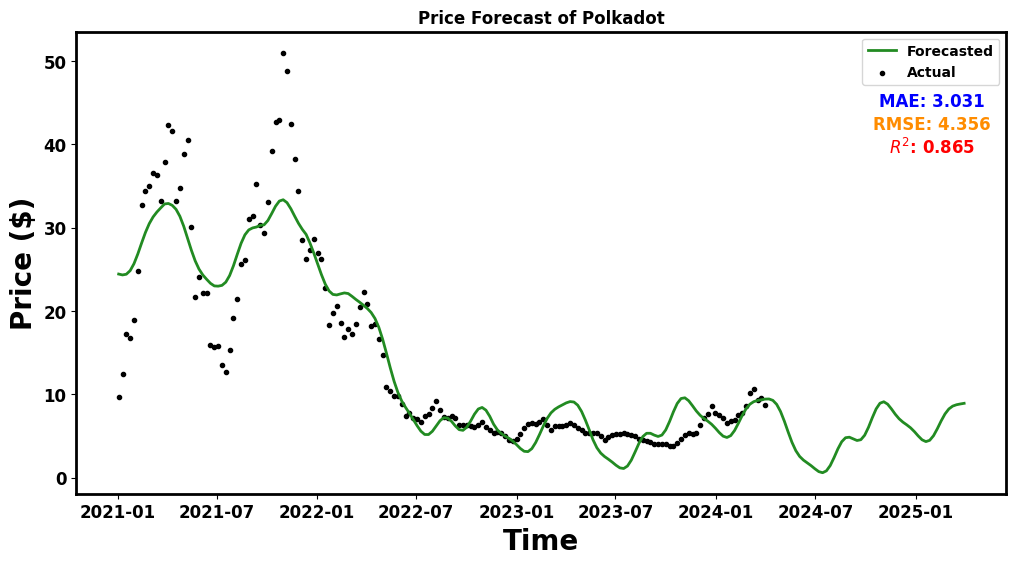

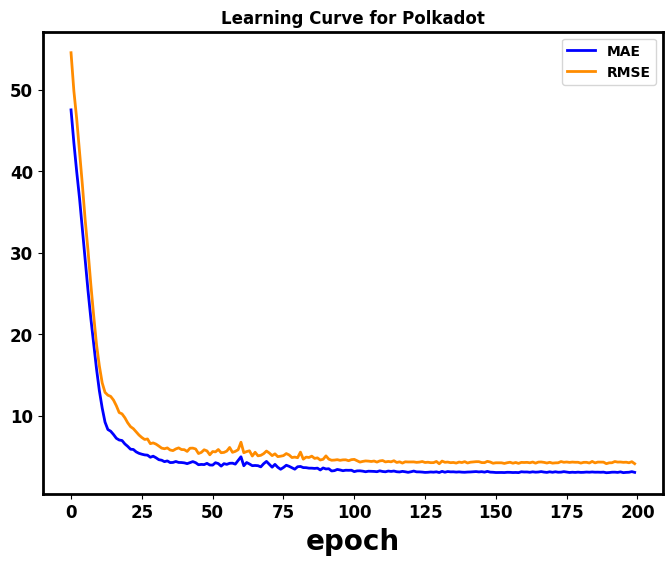


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 251.95it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 367.70it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_monero.pkl.


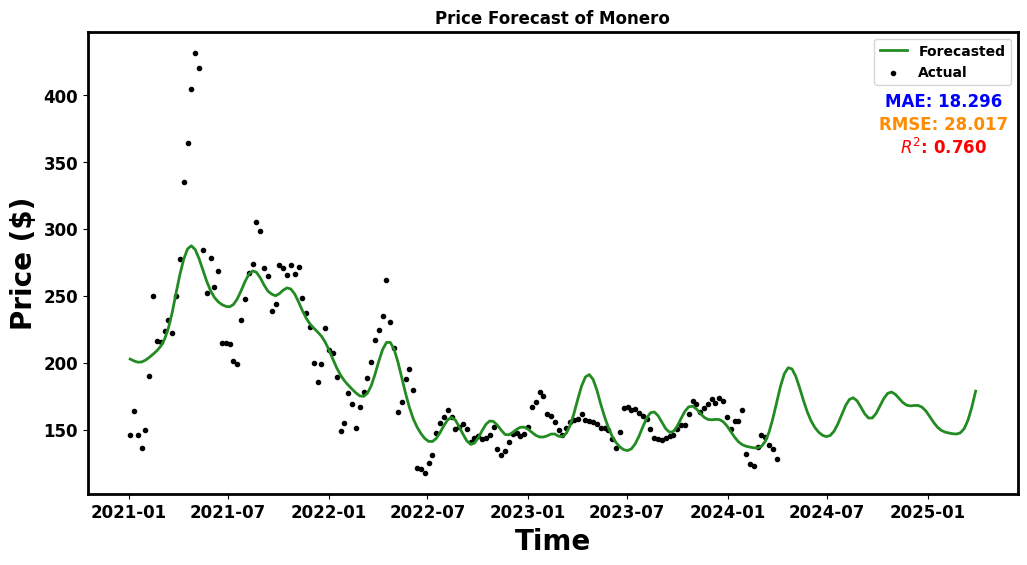

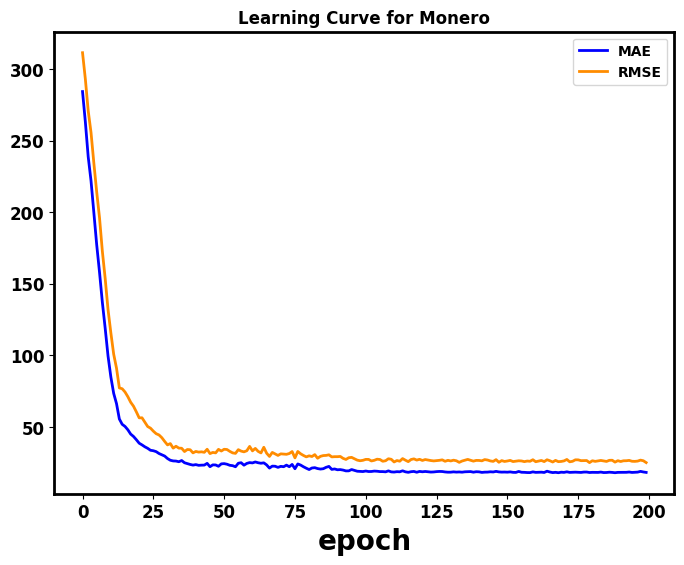


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 247.97it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 355.30it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_XRP.pkl.


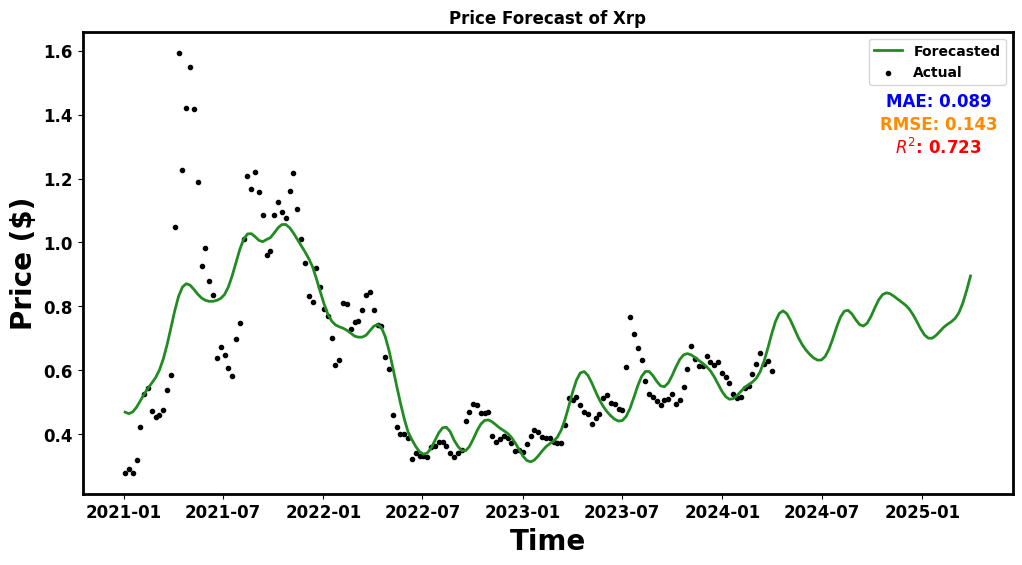

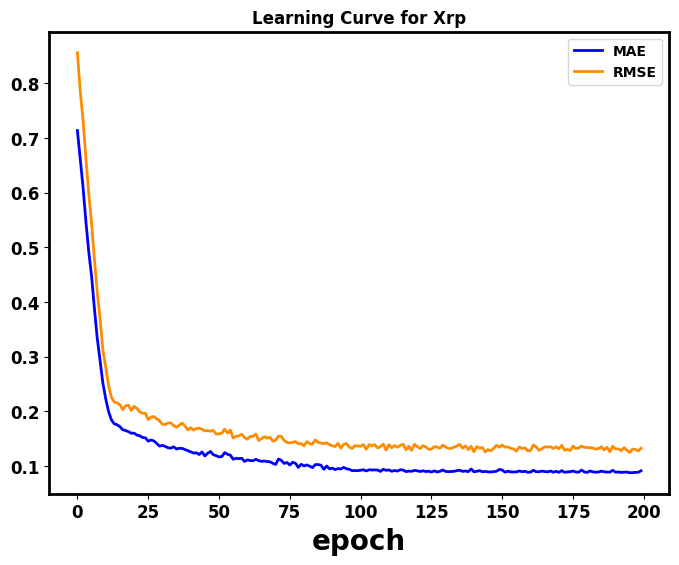


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 253.59it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 353.50it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_ethereum.pkl.


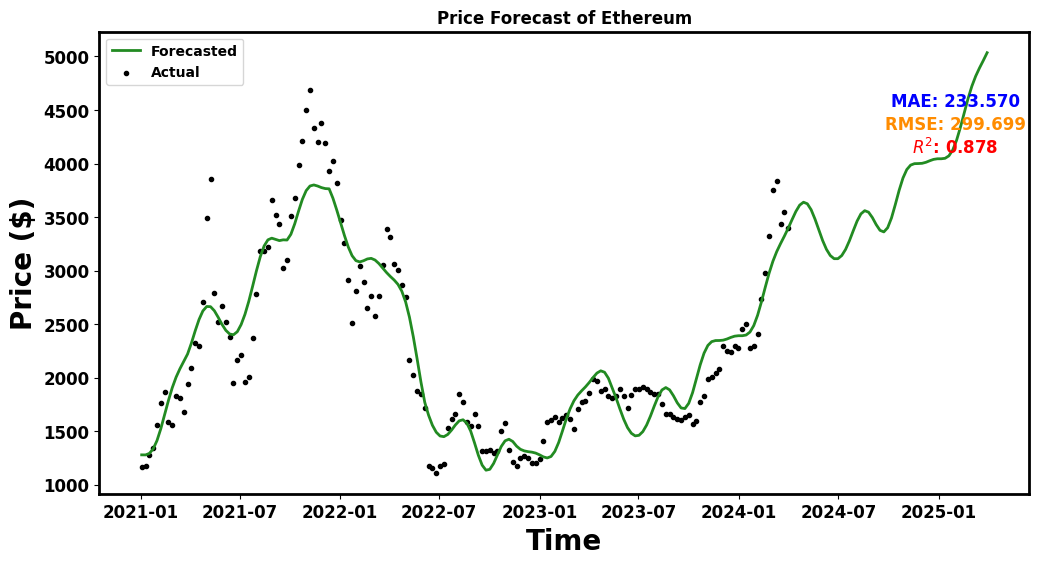

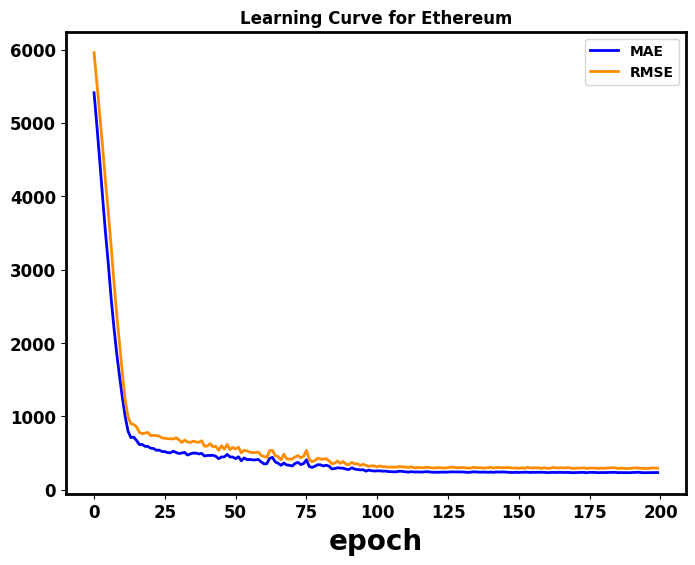


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 254.42it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 355.78it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_ocean protocol.pkl.


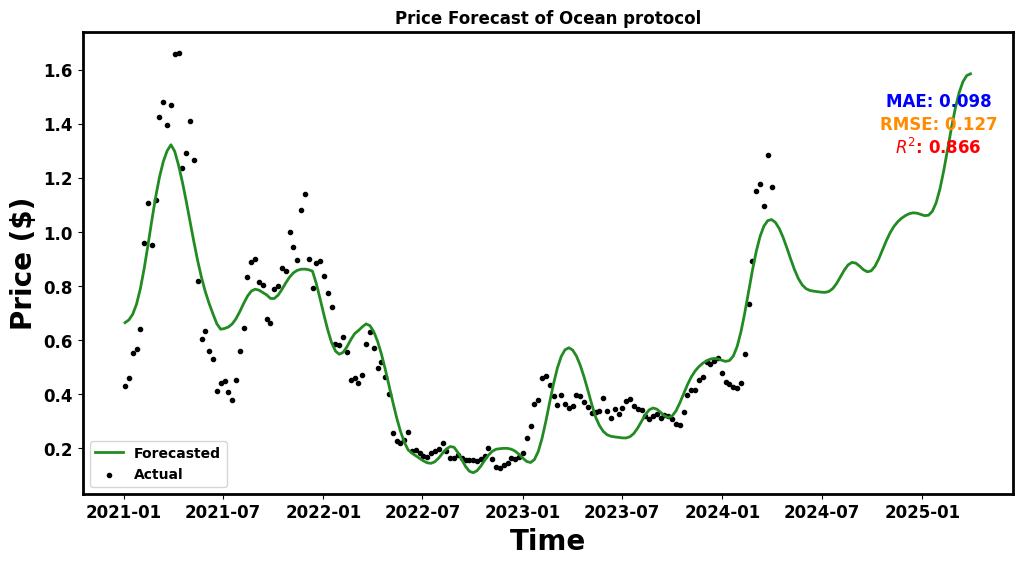

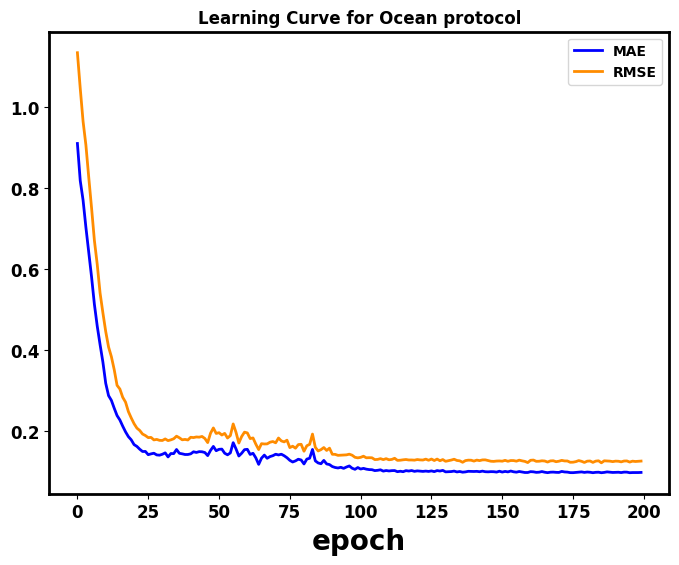


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 244.19it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.33it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_oasis network.pkl.


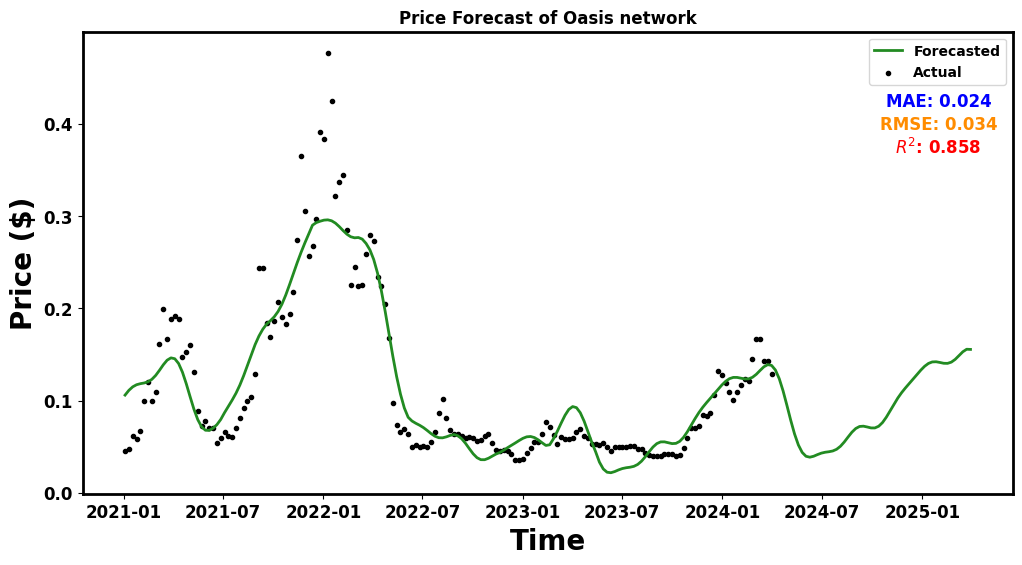

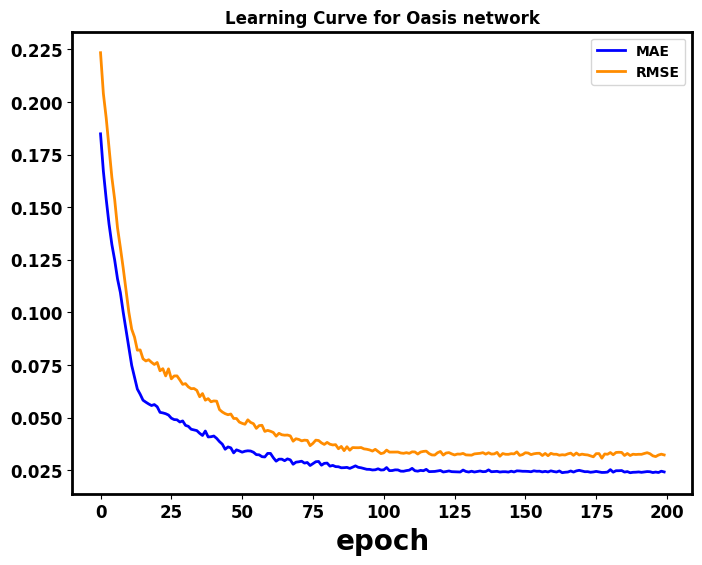


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 255.33it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 285.58it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_kucoin.pkl.


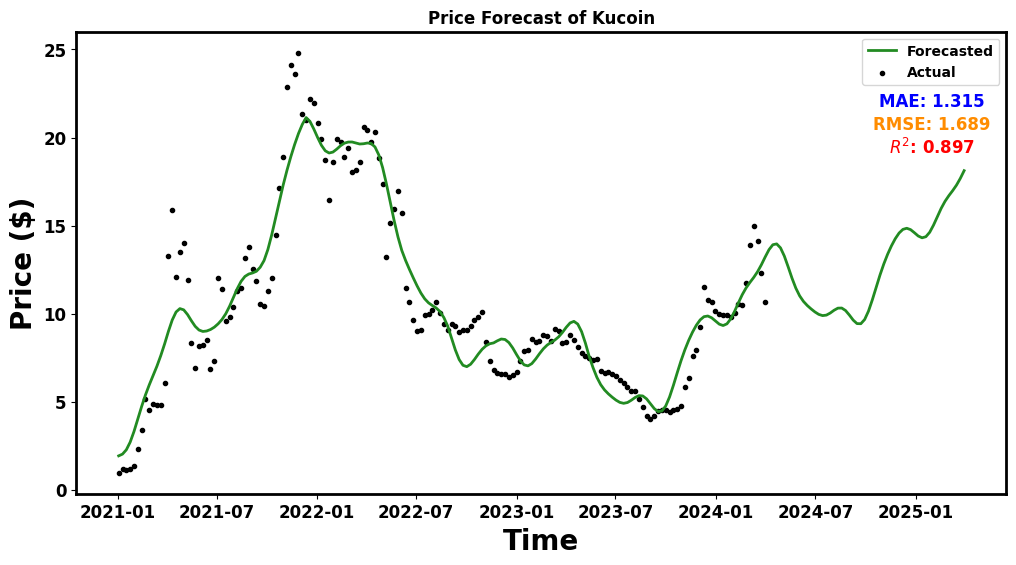

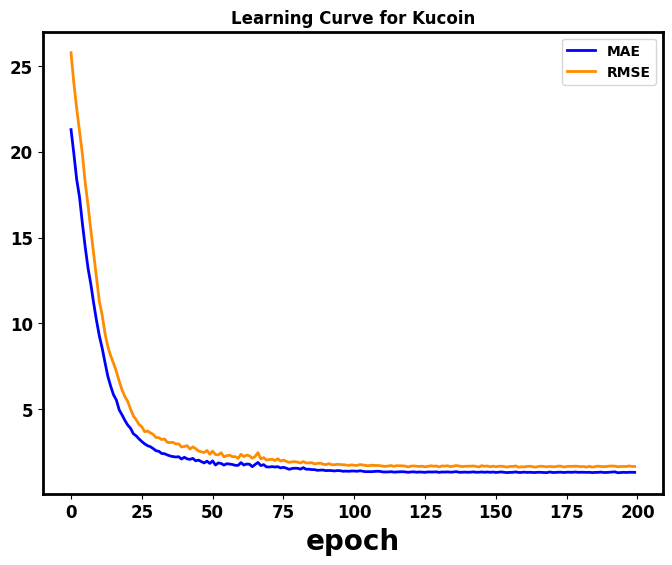


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 255.15it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 270.27it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_dogecoin.pkl.


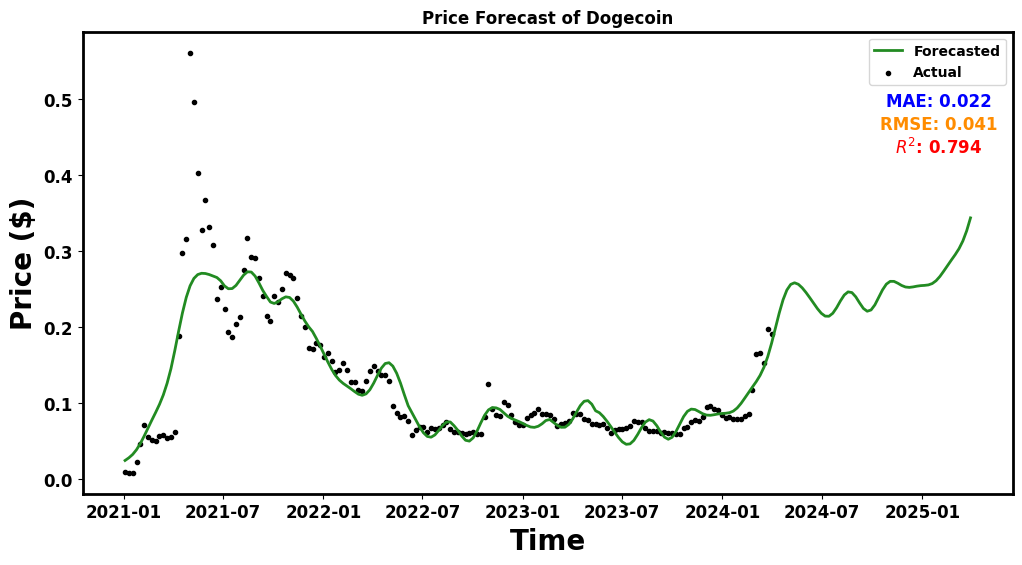

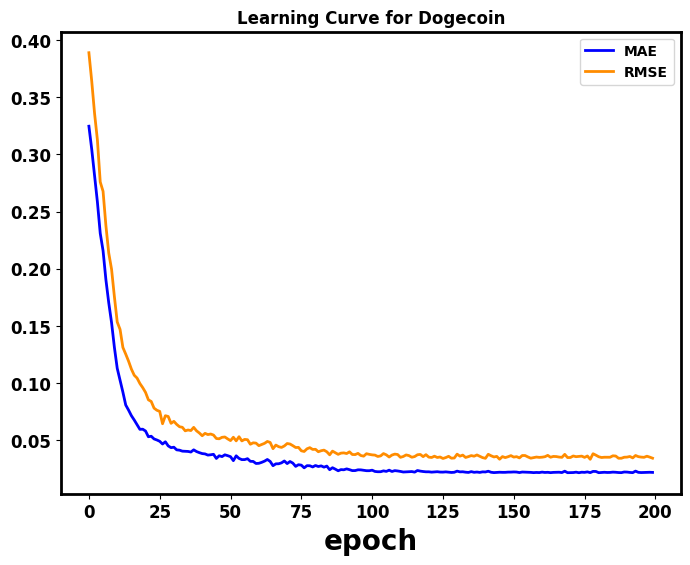


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 247.11it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 395.54it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_bitcoin.pkl.


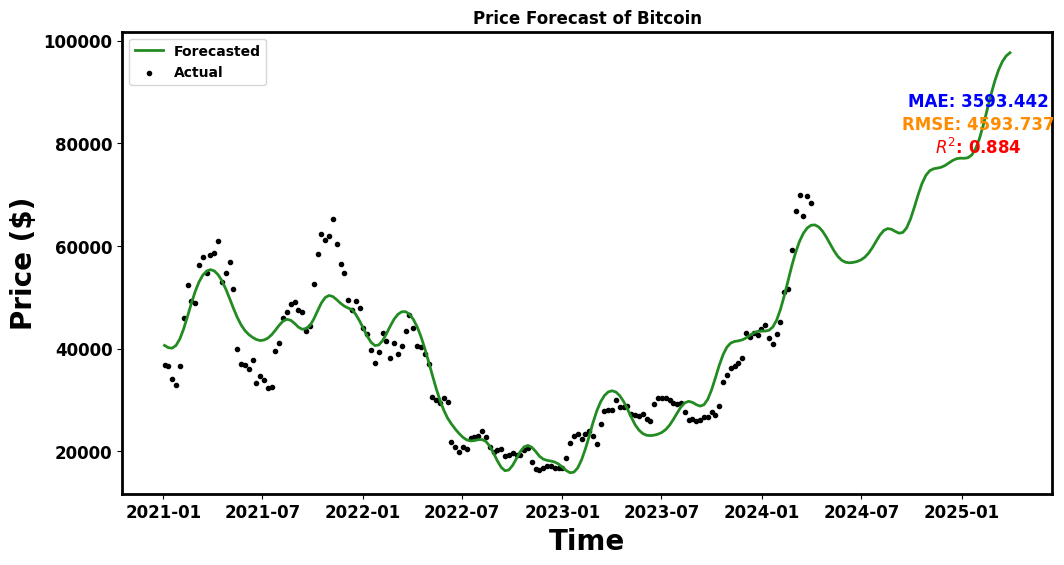

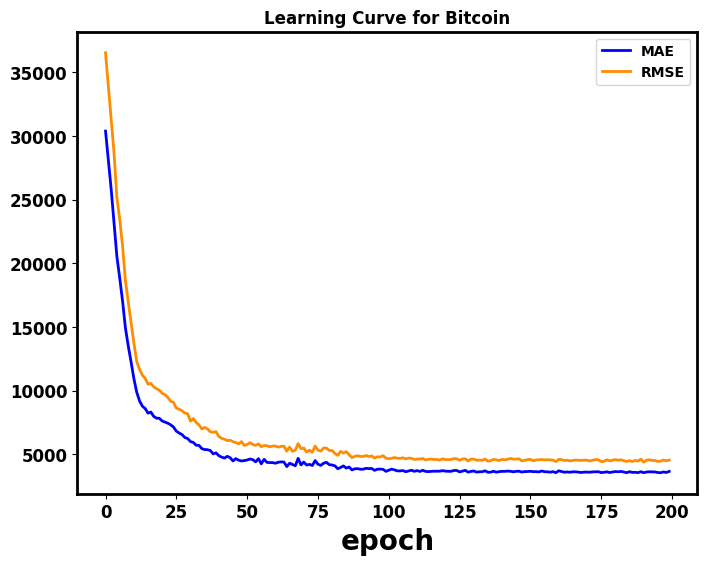


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 249.09it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 356.90it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_fetch.ai.pkl.


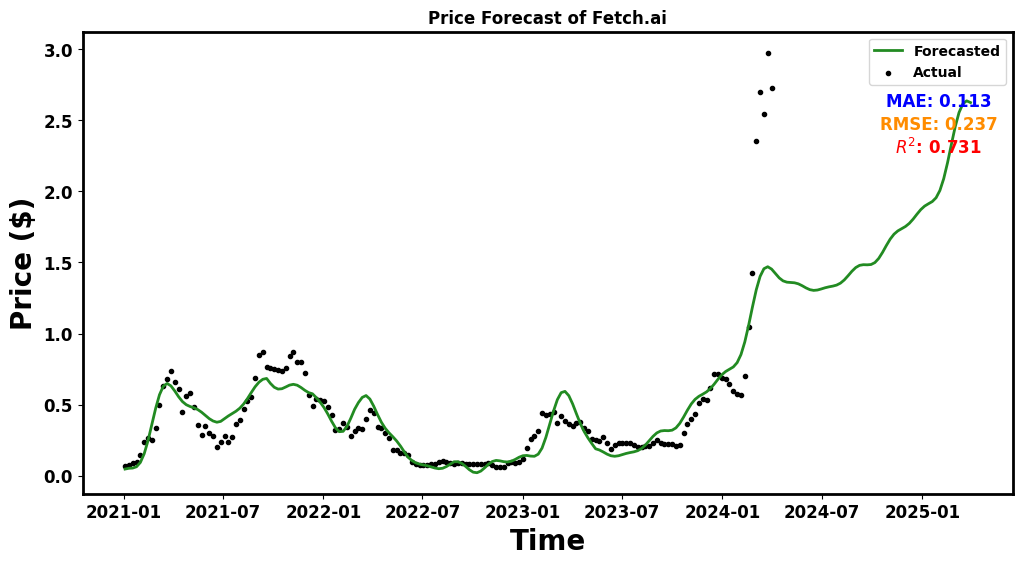

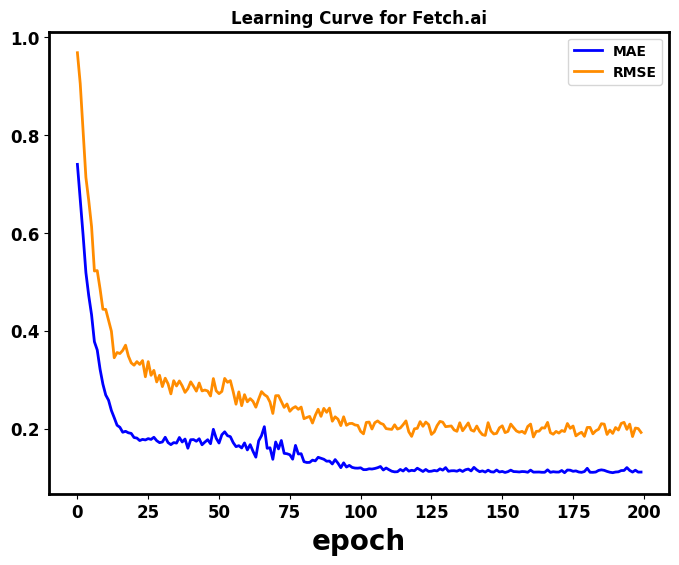


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 245.32it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 389.52it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_singularitynet.pkl.


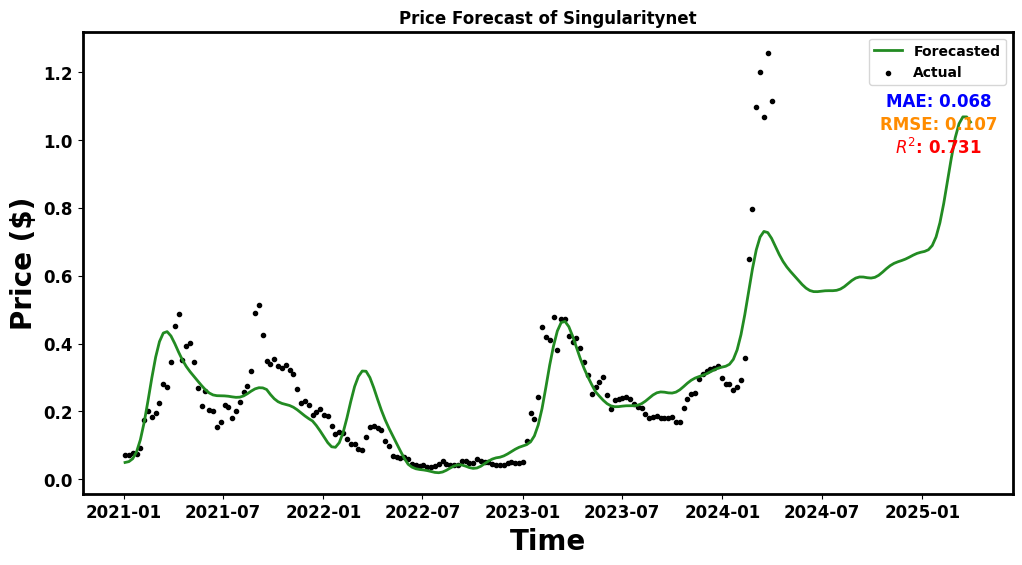

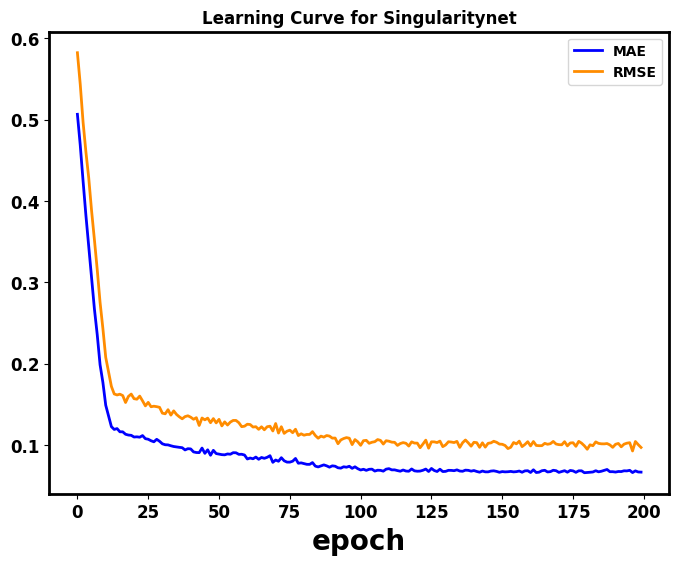


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 240.71it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 339.26it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_litecoin.pkl.


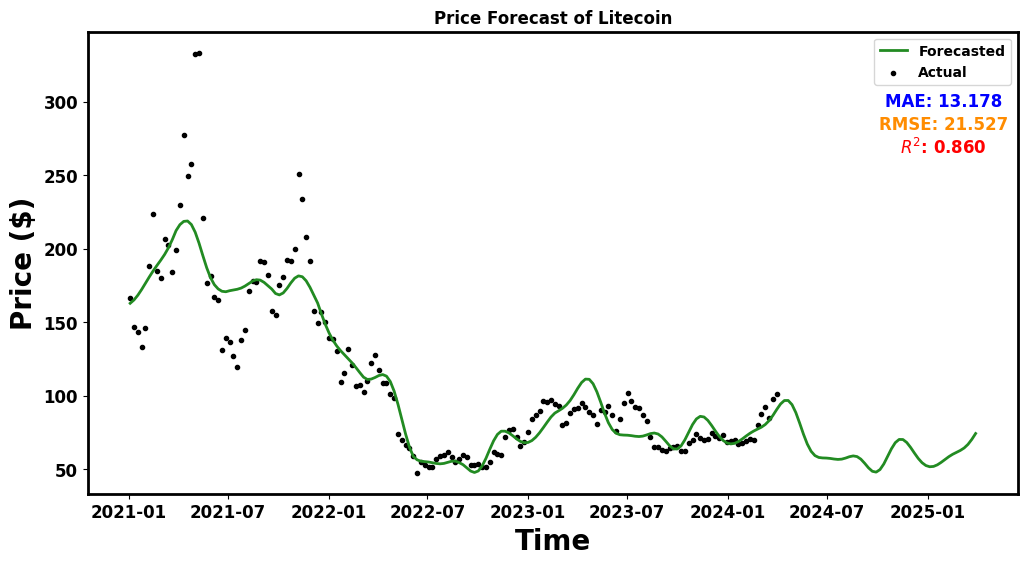

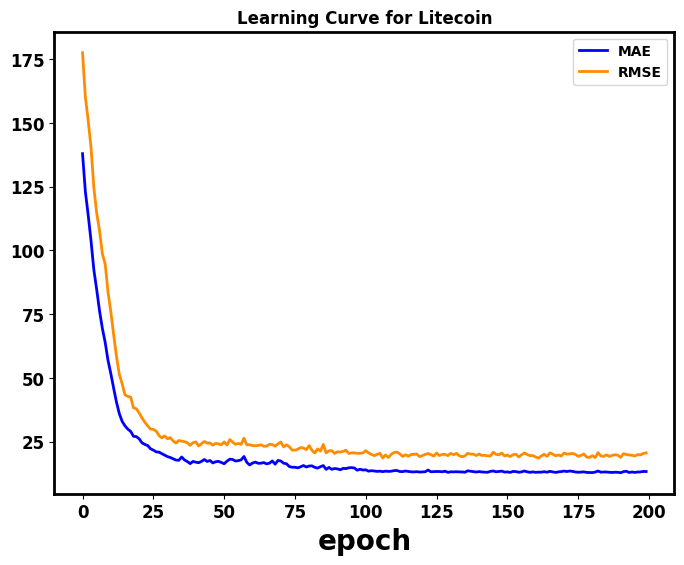


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 258.83it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 288.84it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_uniswap.pkl.


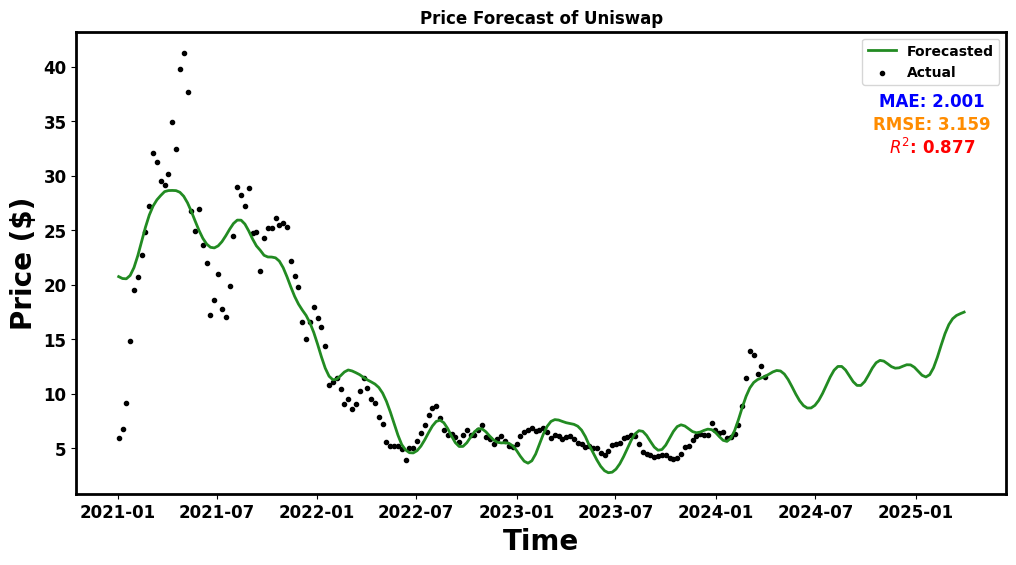

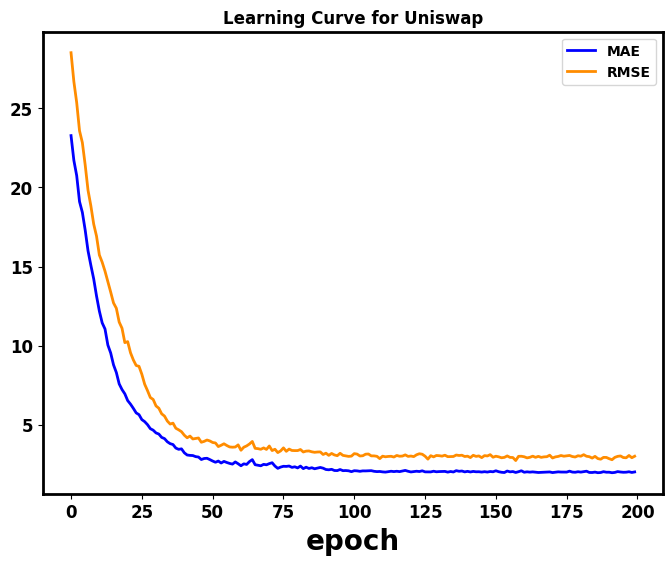


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 230.26it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 346.24it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_filecoin.pkl.


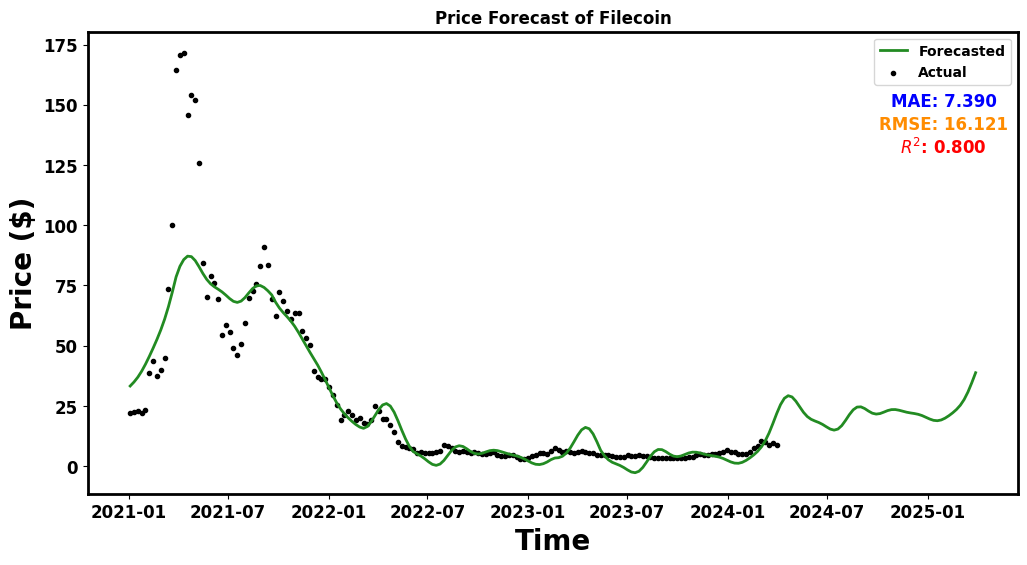

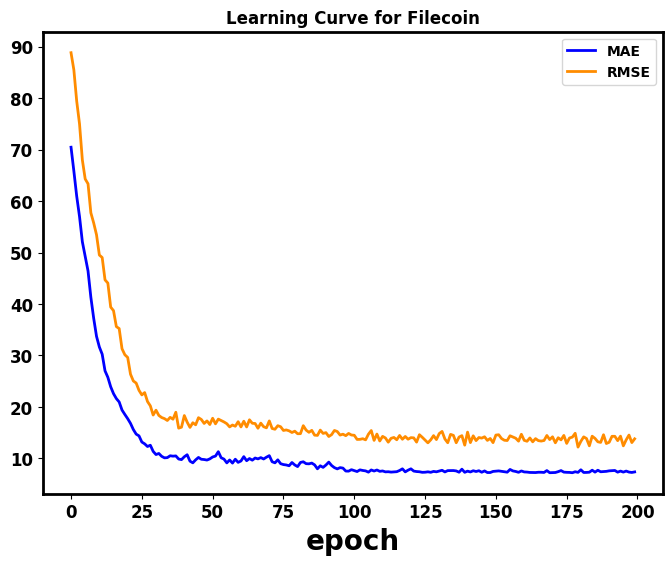


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 268.58it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 237.58it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_pancakeswap.pkl.
Epoch 138:  69%|██████████▎    | 138/200 [05:22<02:25,  2.34s/it, loss=0.0165, v_num=111, MAE=0.0241, RMSE=0.040, Loss=0.0162, RegLoss=0.000]


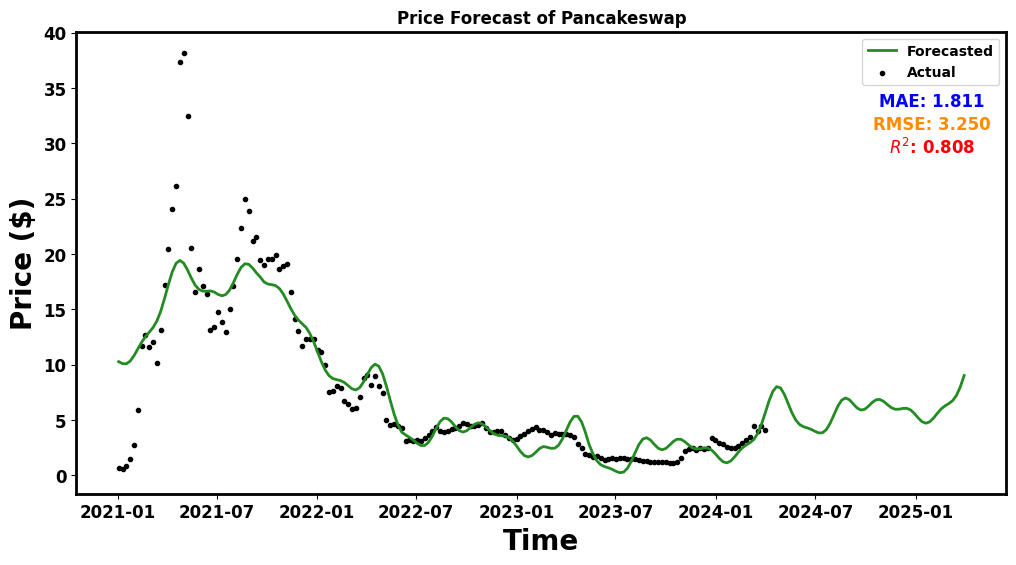

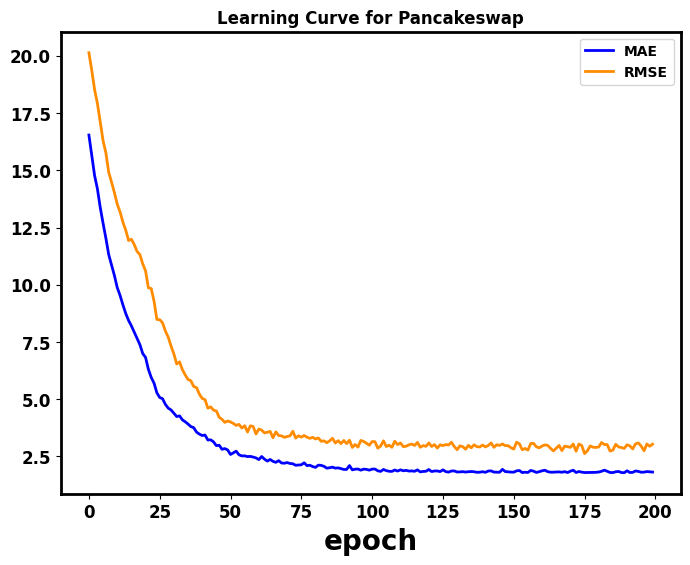


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 244.20it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 223.14it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_bnb.pkl.


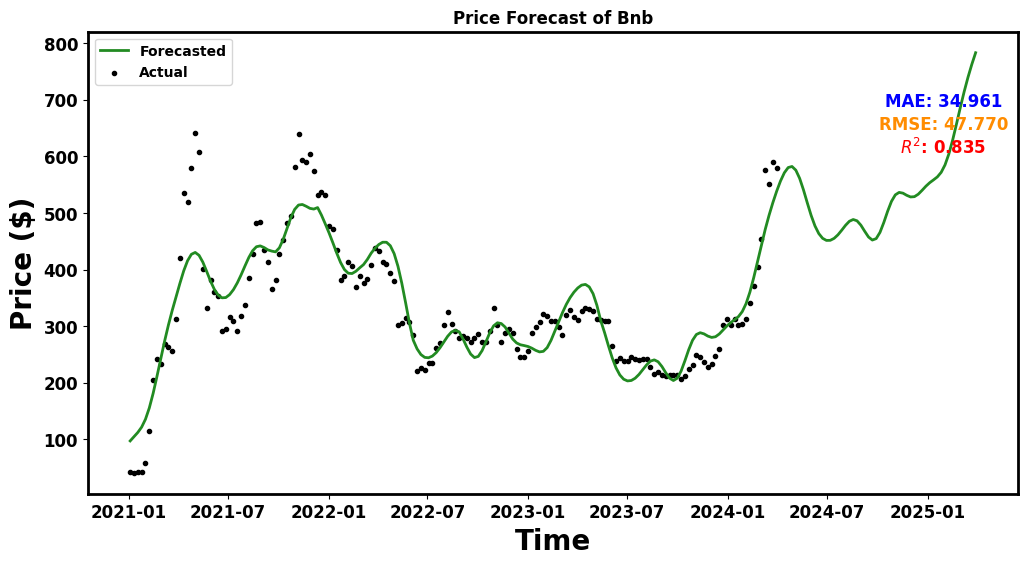

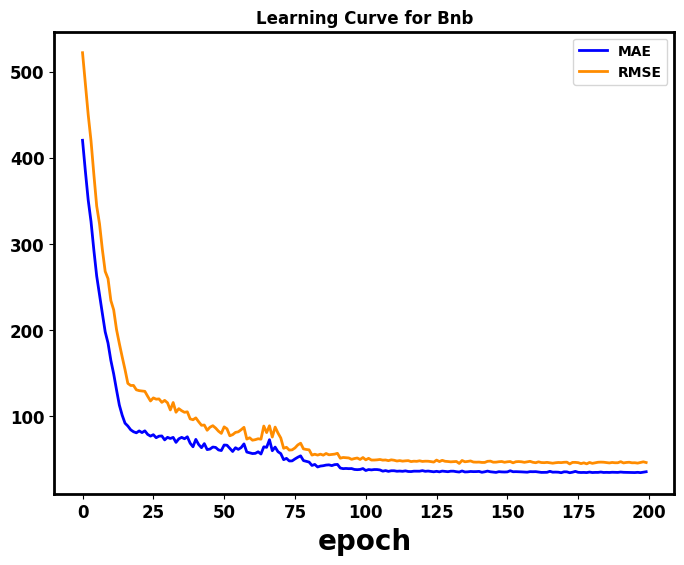


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 238.34it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 296.21it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_tezos.pkl.


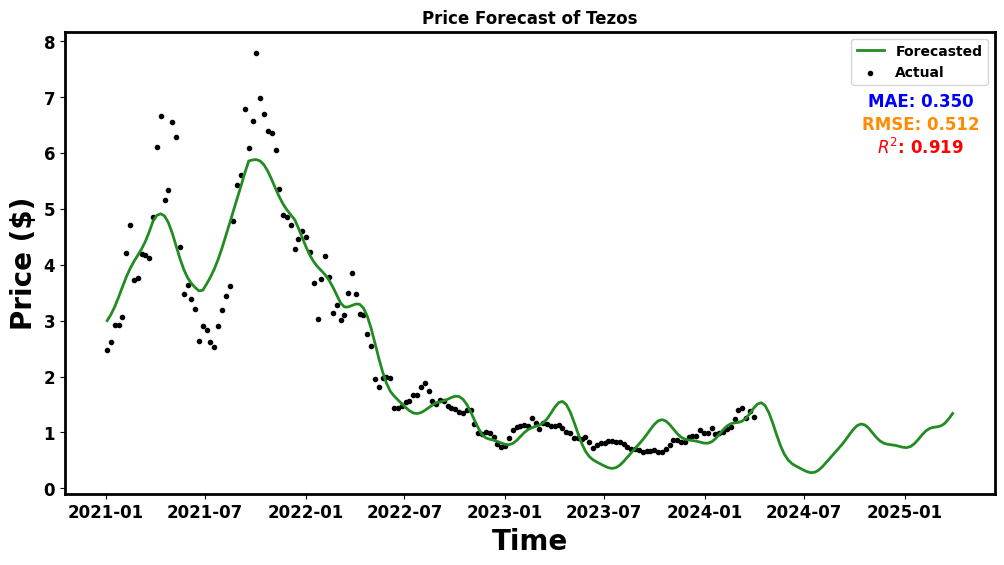

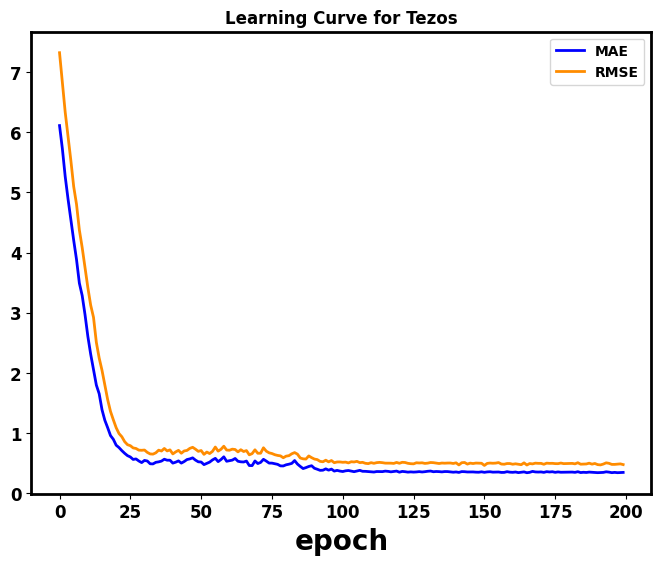


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 243.97it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 276.05it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_chainlink.pkl.


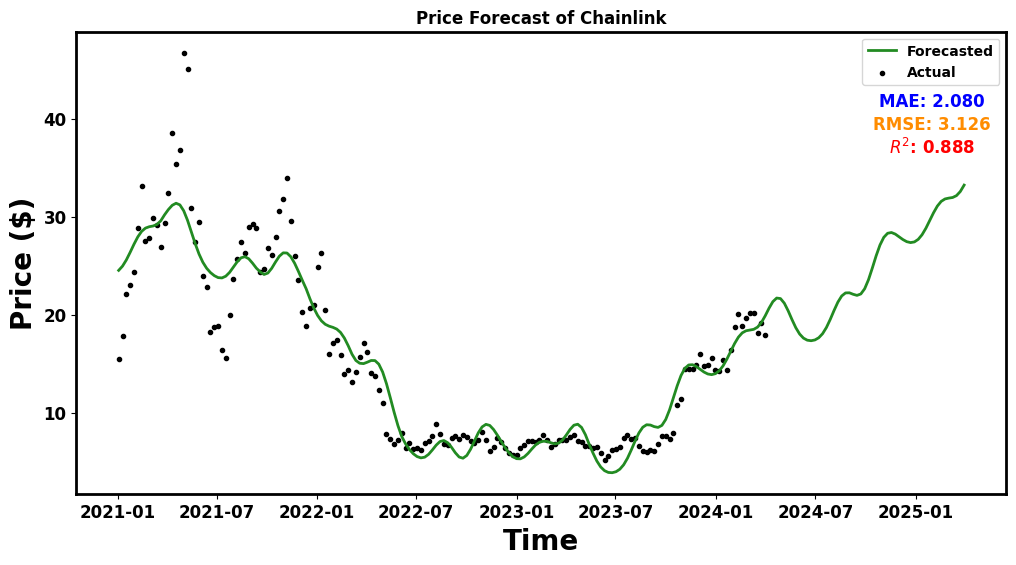

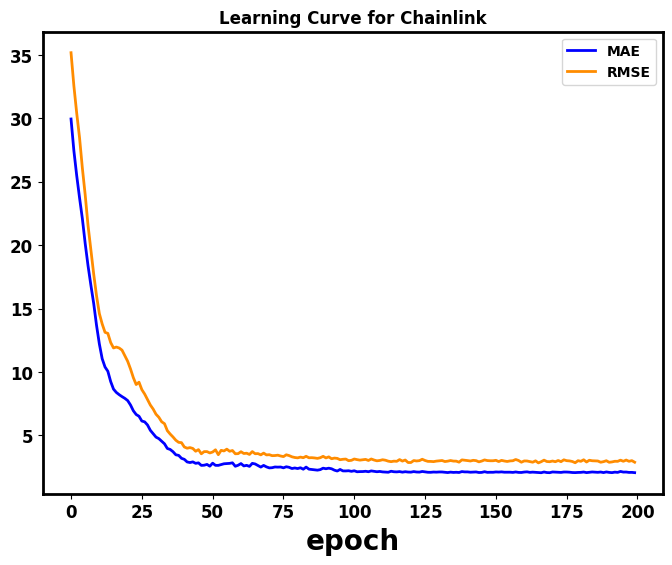


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 247.95it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 406.39it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_cardano.pkl.


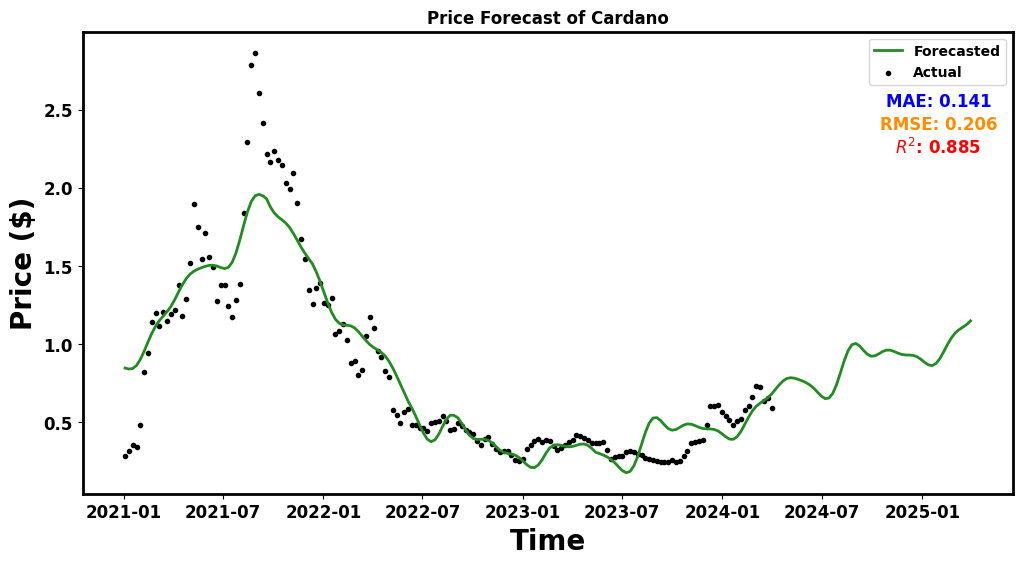

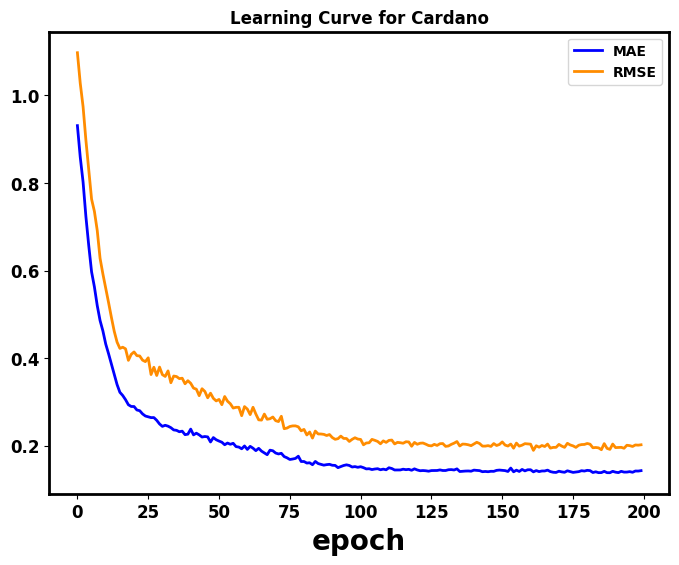


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 246.57it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 308.20it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/price_m0_solana.pkl.


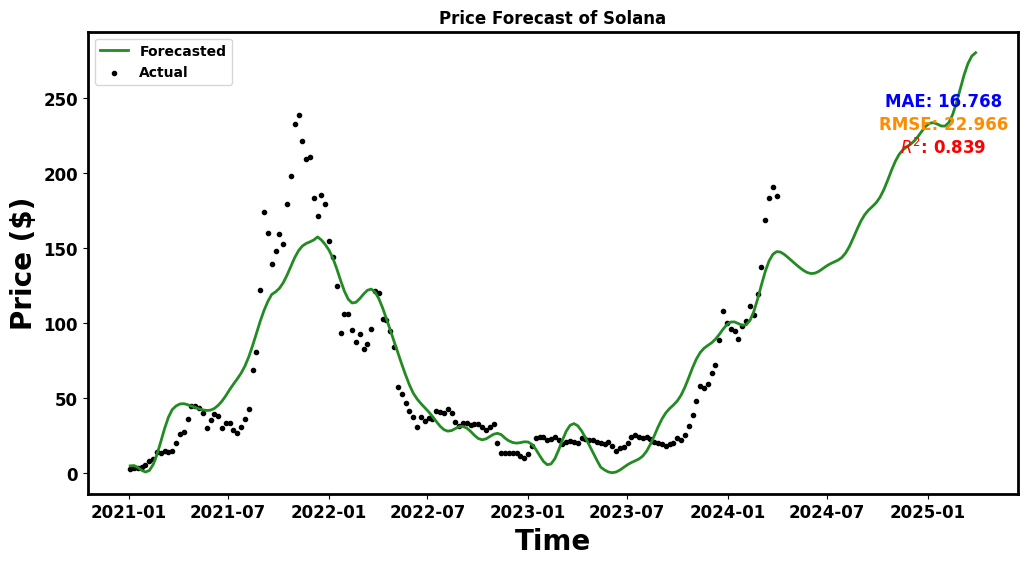

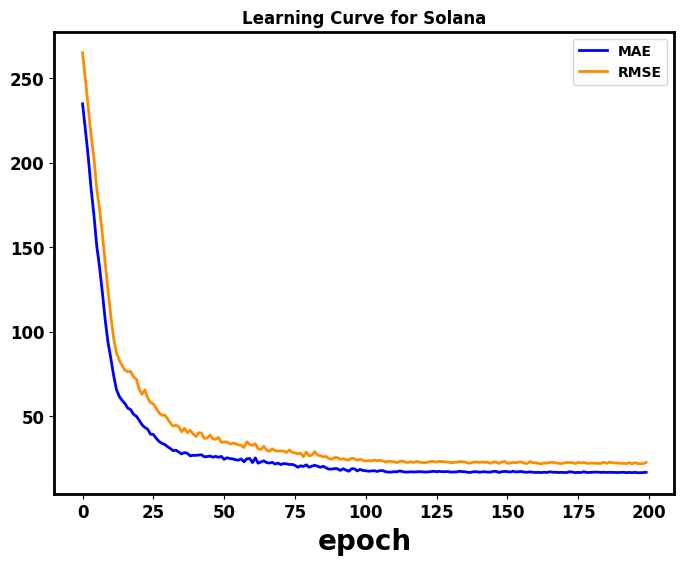

In [118]:
## Price Forecast

for c in namelist :
    naming = 'price_m0'
    df =  myprice = combined_df_dict[c][['Start_Date','Close_Ave']]
    df.columns = ['ds','y']
    # Create a NeuralProphet model with default parameters
    m0 = NeuralProphet() # Always initialize to avoid fitted model refitted.
    model = m0
    future_duration = 52 # 52 weeks or a Year
    result = deploy_predict(model, df,future_duration)

    # Save result right away
    filepath = f'/home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/{naming}_{c}.pkl'
    filedict = result
    DC.save_dict(filepath,filedict)

    # Plot and save result
    Plot_price(result, c, naming)



## M0 

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 245.19it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 315.27it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_polkadot.pkl.


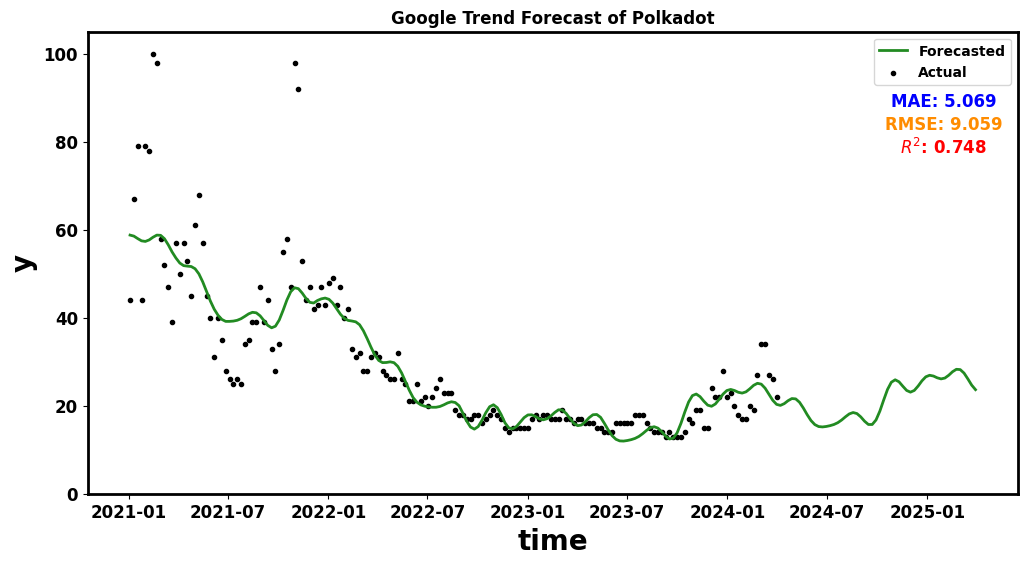

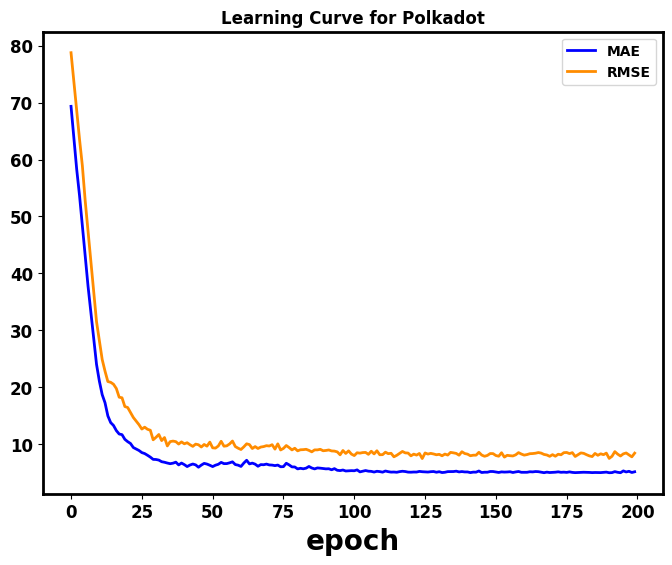

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 248.28it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 279.29it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_monero.pkl.


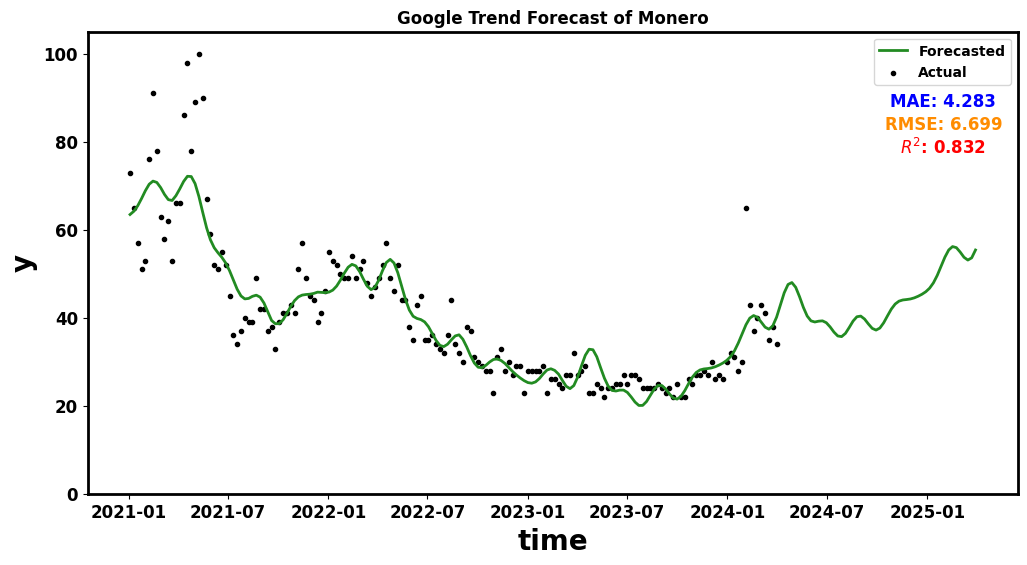

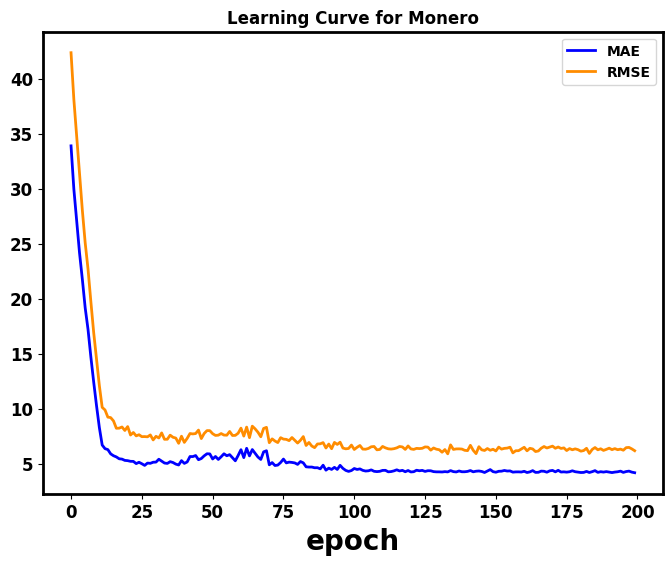

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 247.72it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 322.56it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_XRP.pkl.


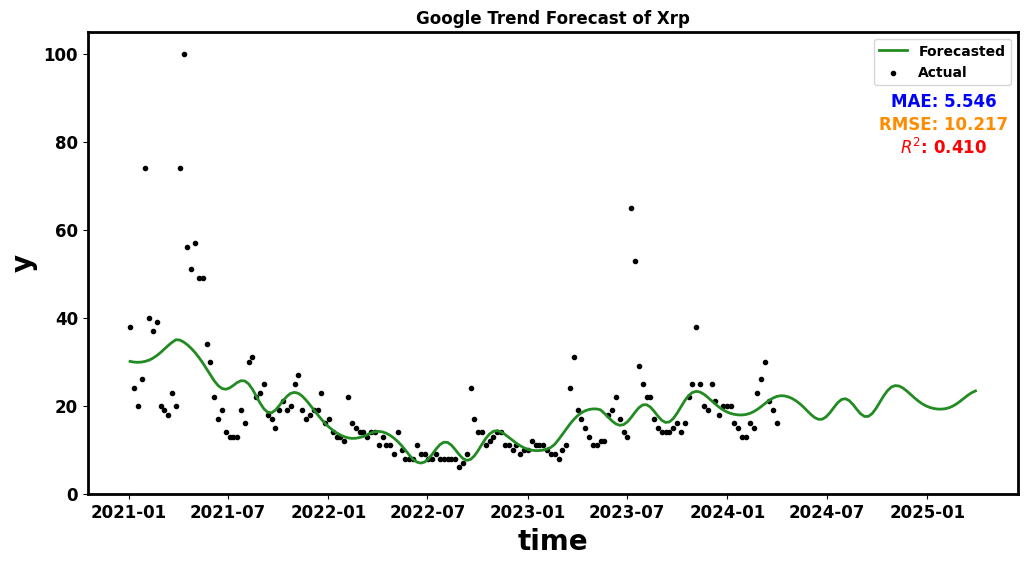

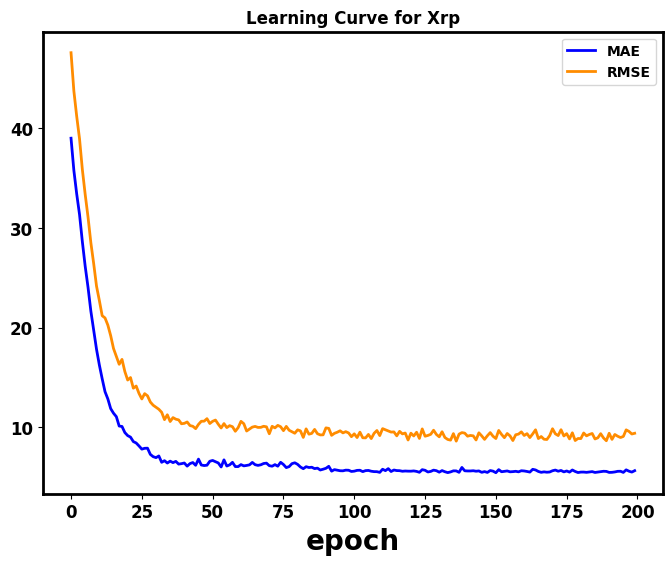

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 275.69it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 338.17it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_ethereum.pkl.


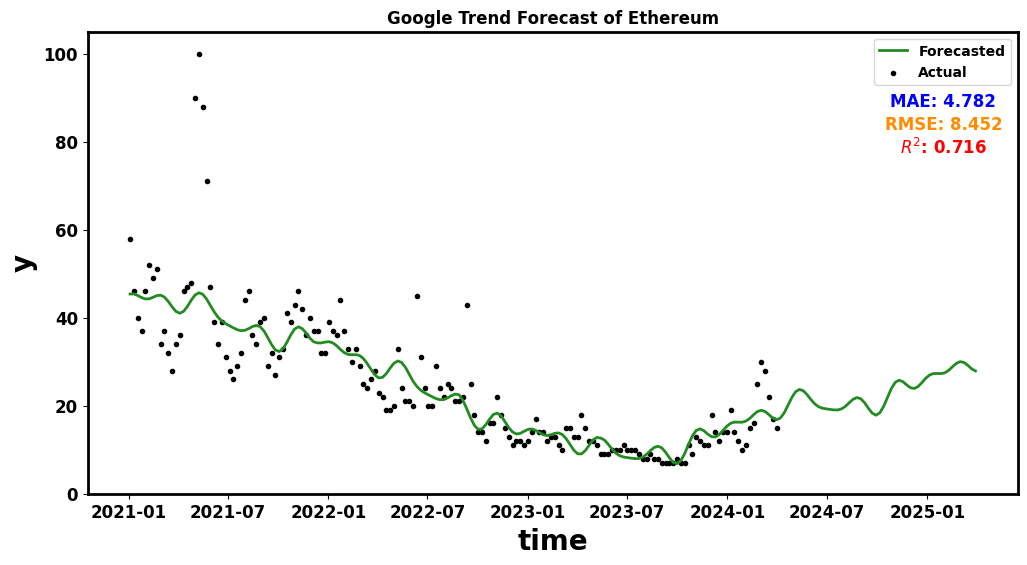

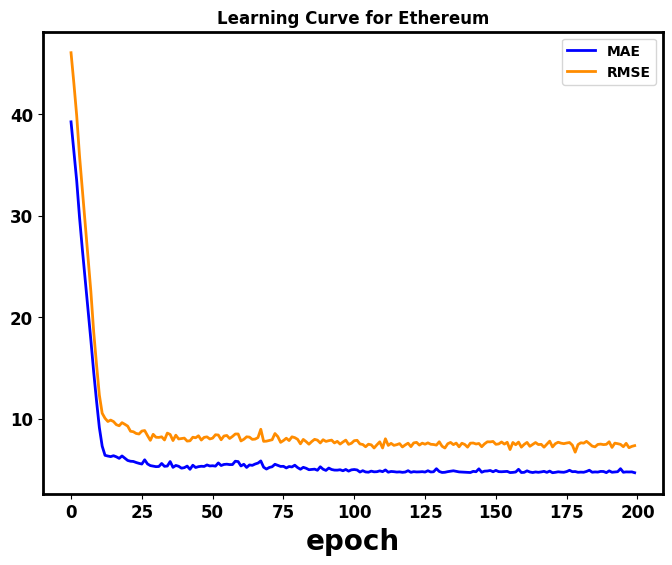

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 260.11it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 278.56it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_ocean protocol.pkl.


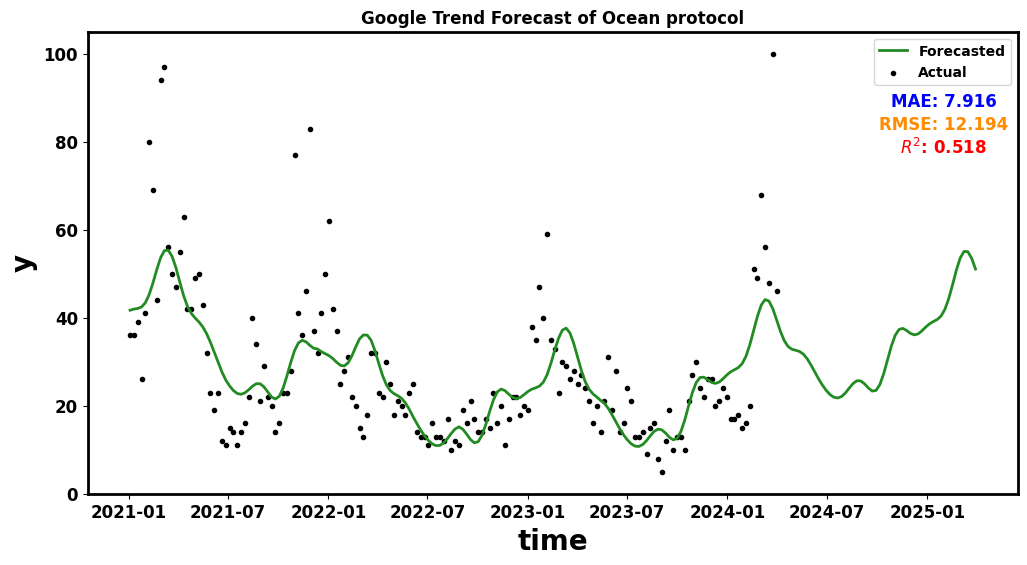

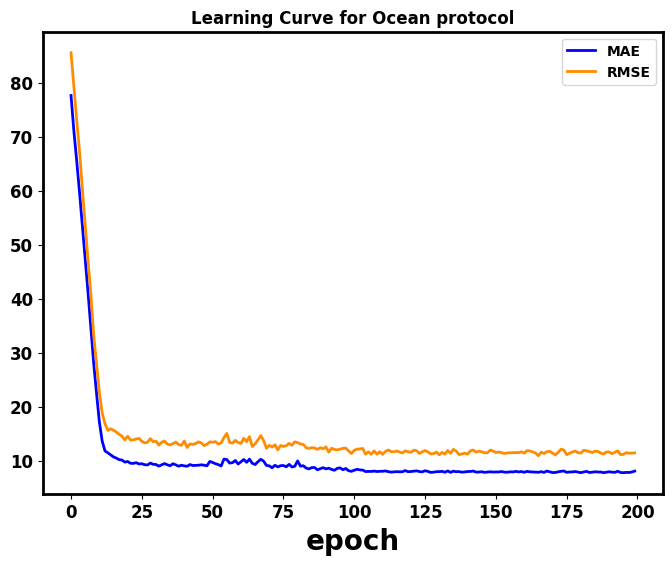

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 275.53it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 463.61it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_oasis network.pkl.


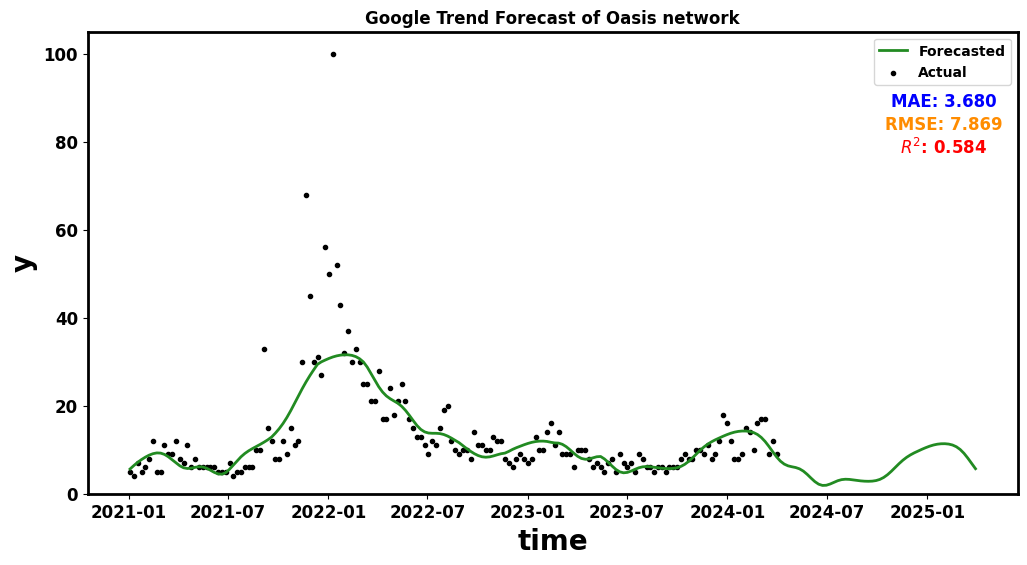

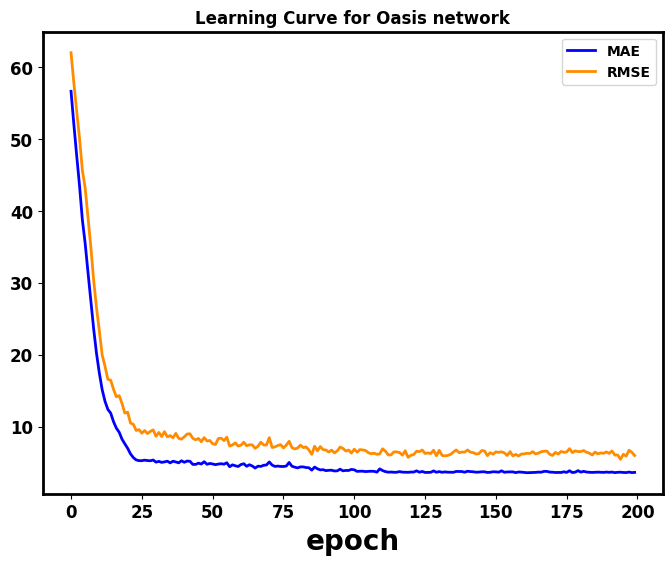

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 263.15it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 300.37it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_kucoin.pkl.


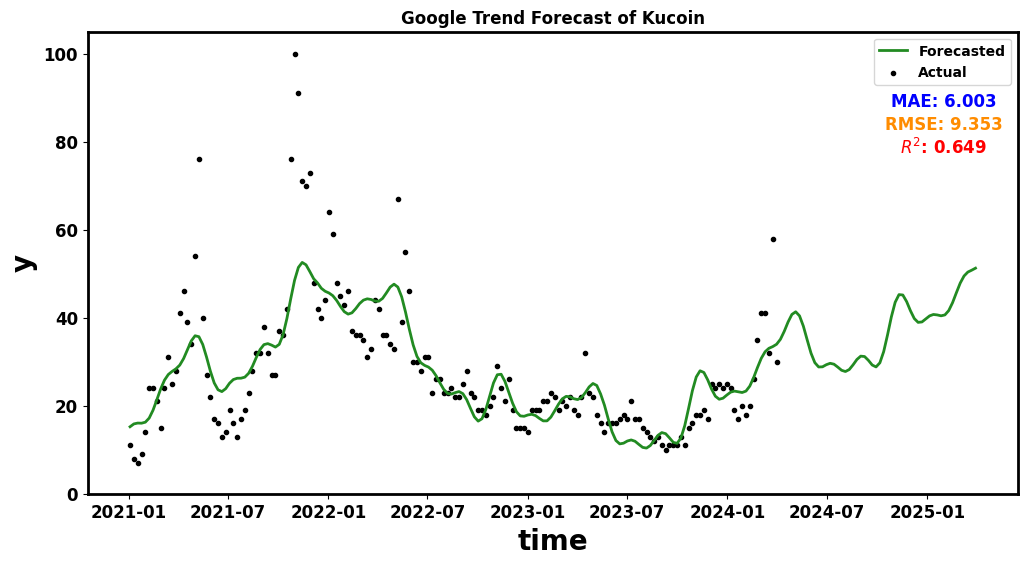

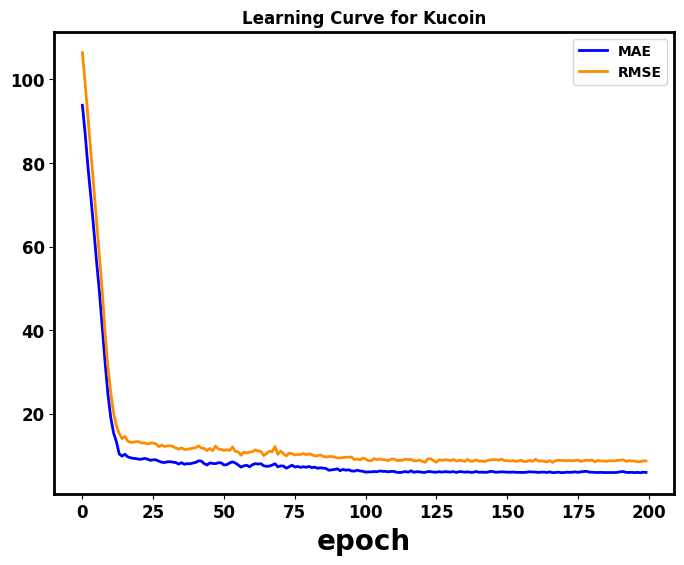

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 247.24it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 315.81it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_dogecoin.pkl.


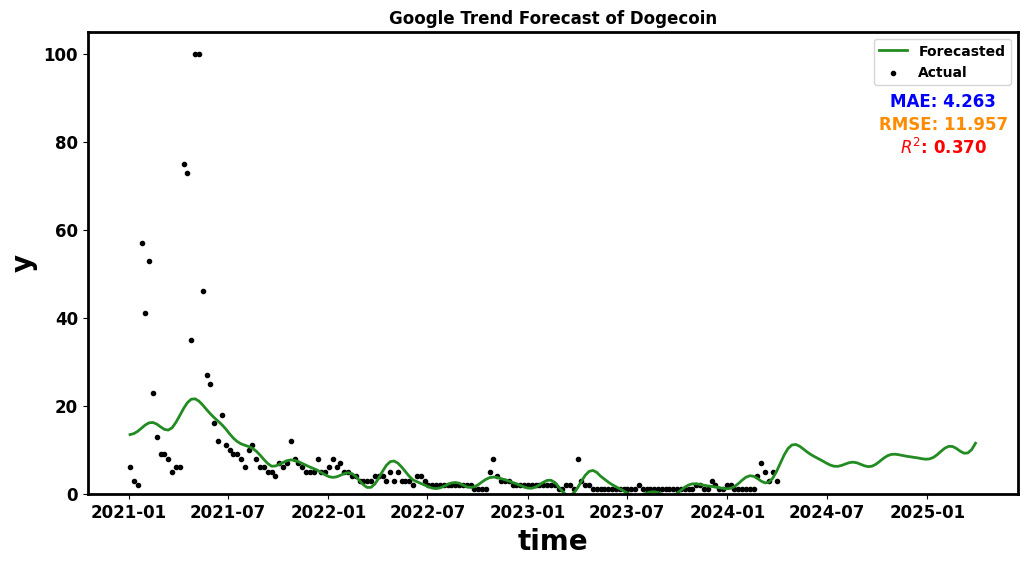

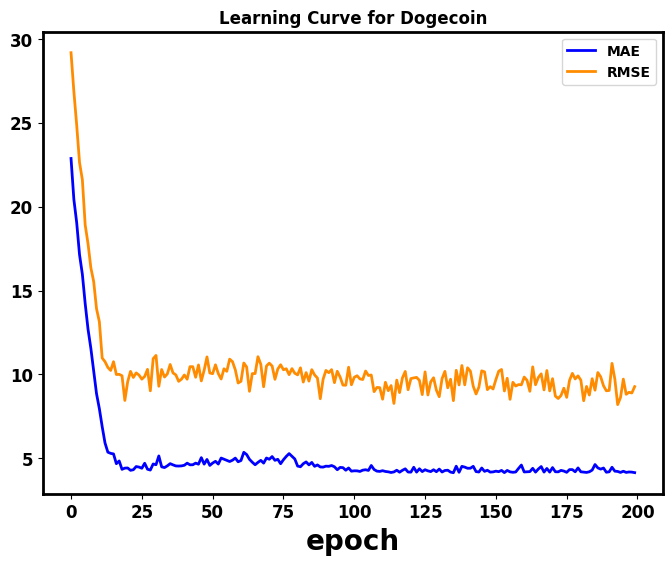

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 265.51it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 272.59it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_bitcoin.pkl.


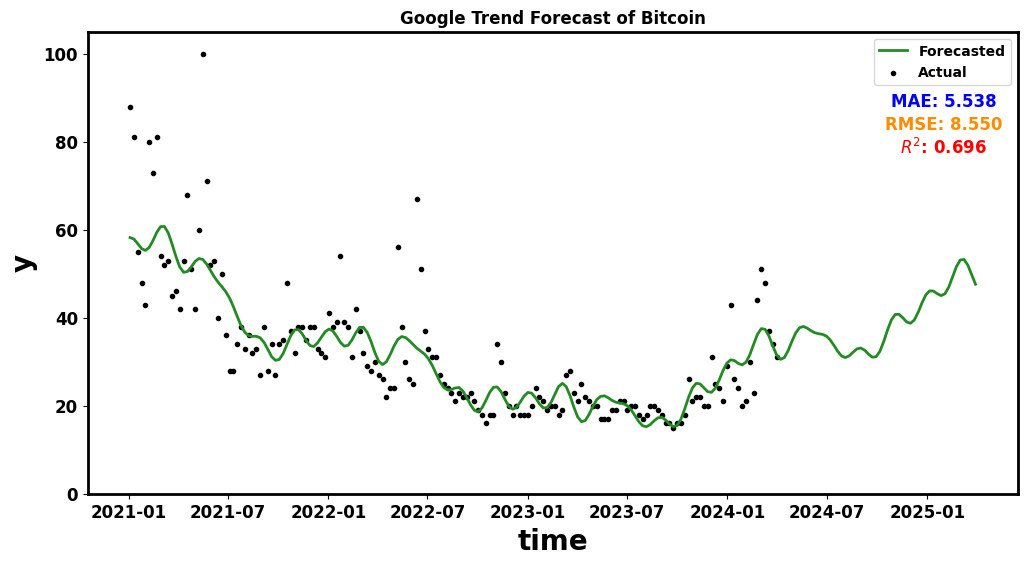

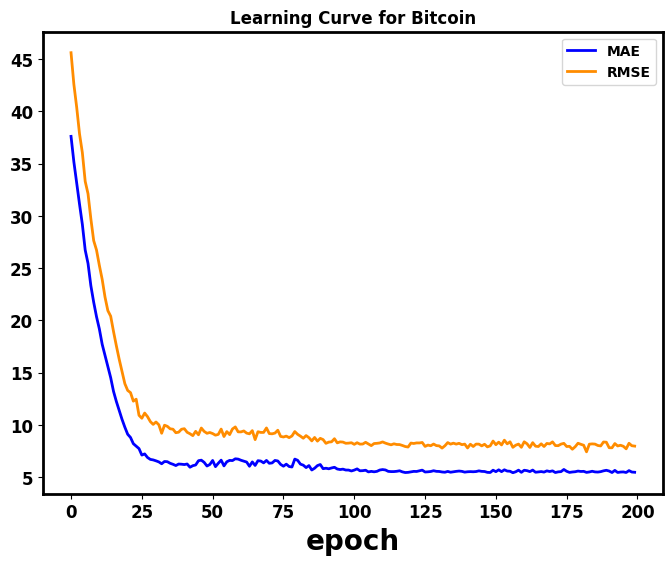

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 245.82it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 291.41it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_fetch.ai.pkl.


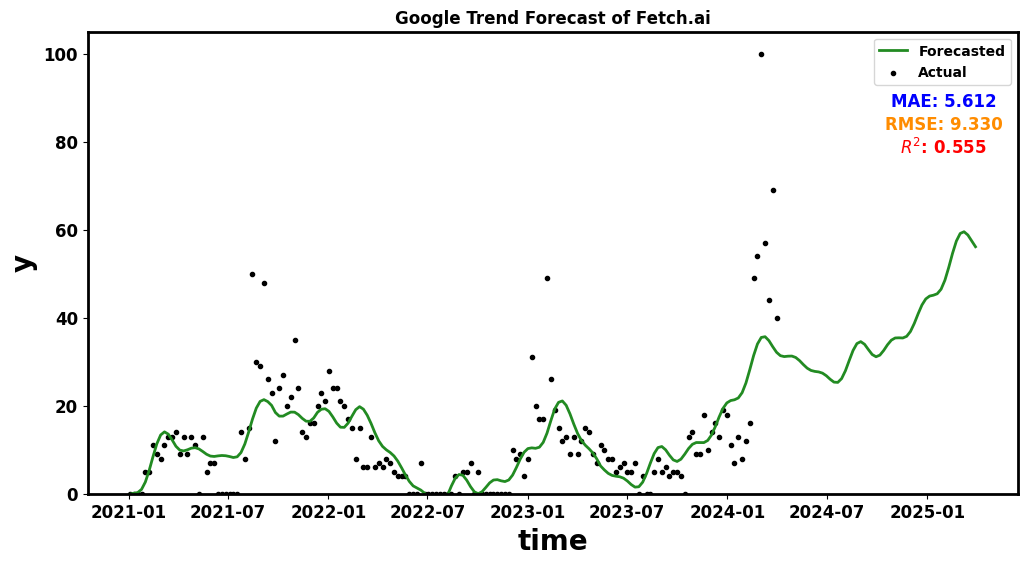

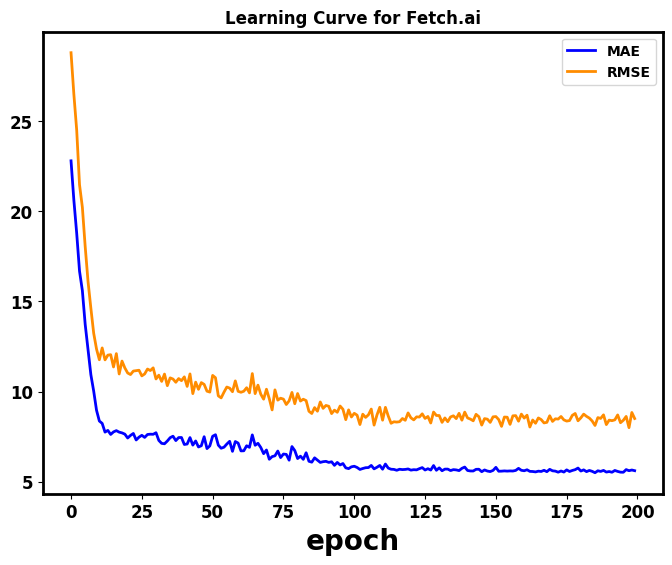

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 252.40it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 309.70it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_singularitynet.pkl.


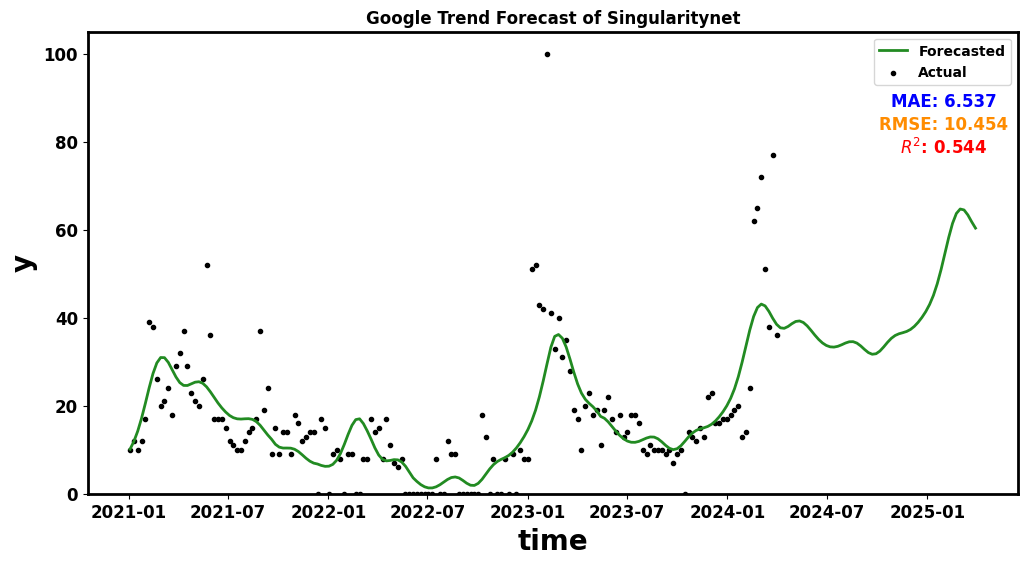

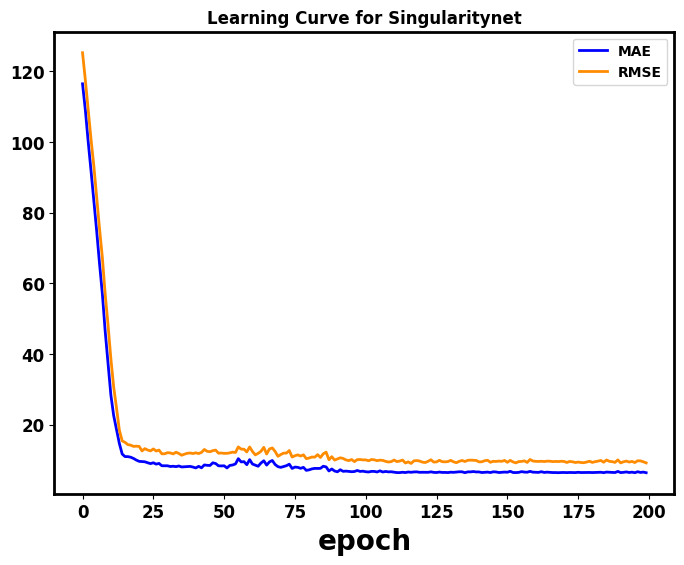

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 245.97it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 260.02it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_litecoin.pkl.


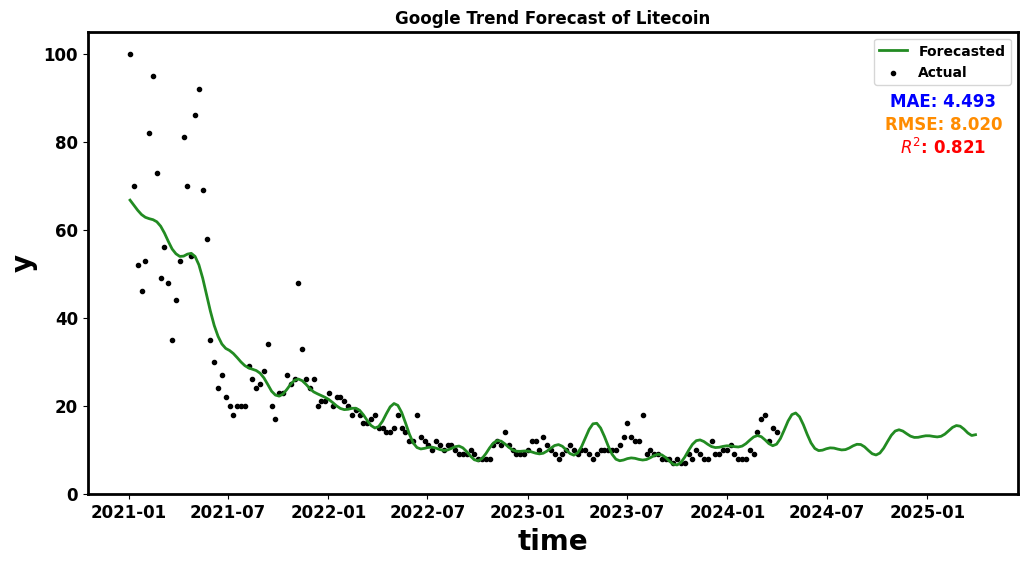

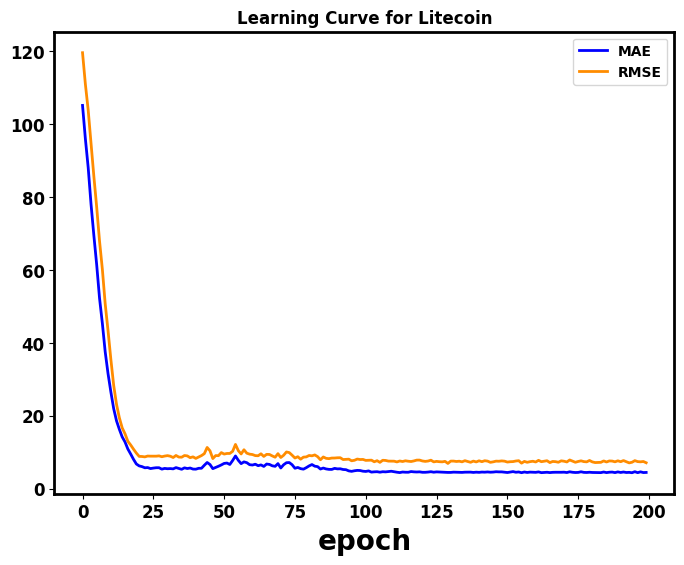

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 266.03it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 340.09it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_uniswap.pkl.


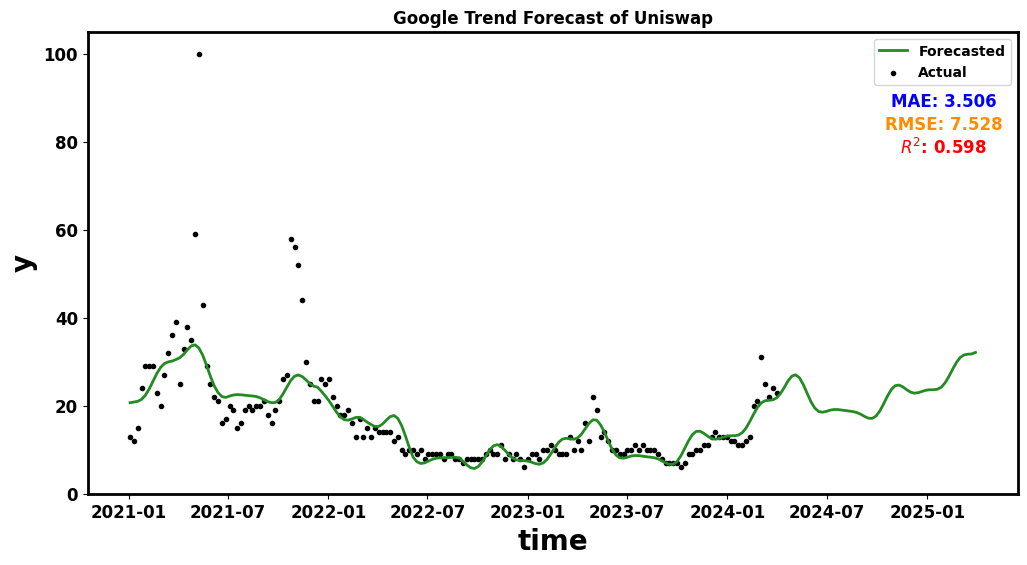

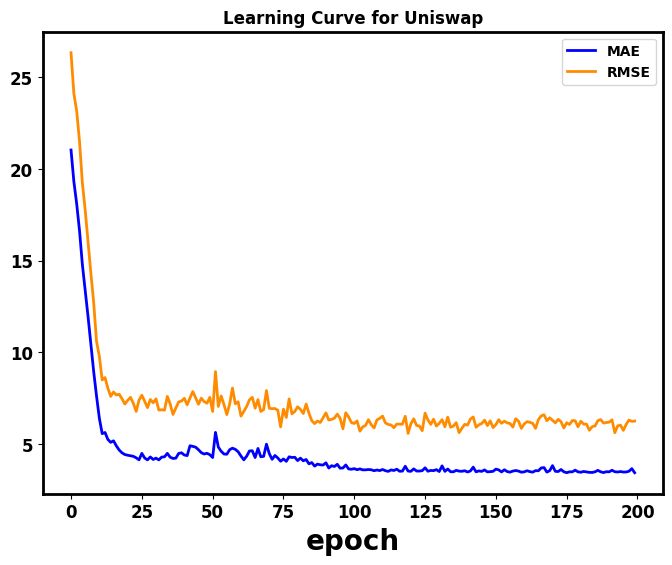

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 249.03it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 261.70it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_filecoin.pkl.


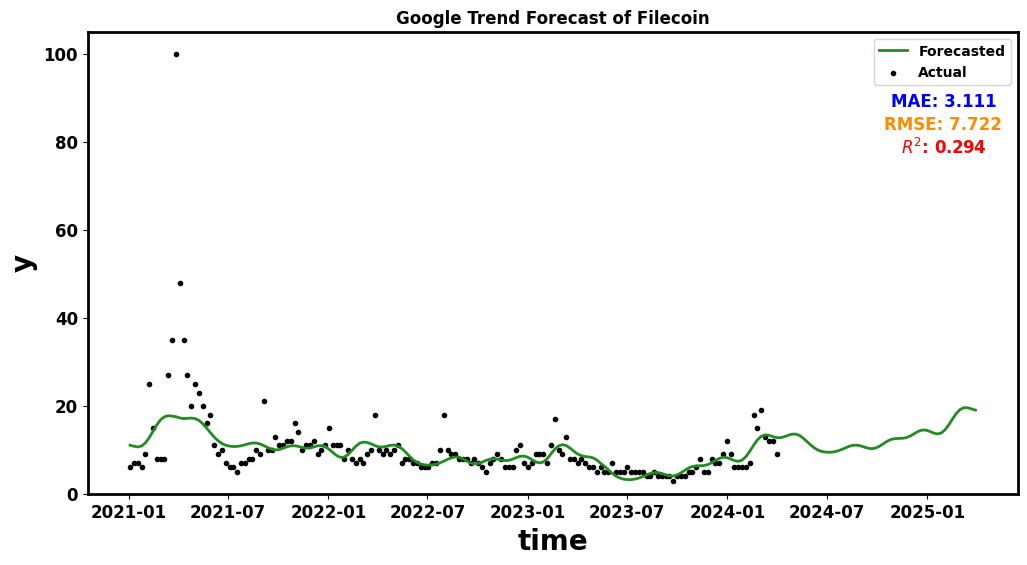

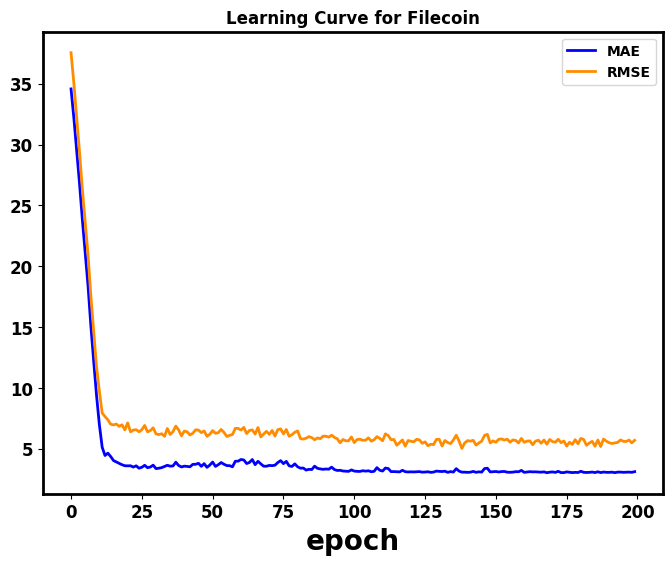

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 261.67it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 330.65it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_pancakeswap.pkl.


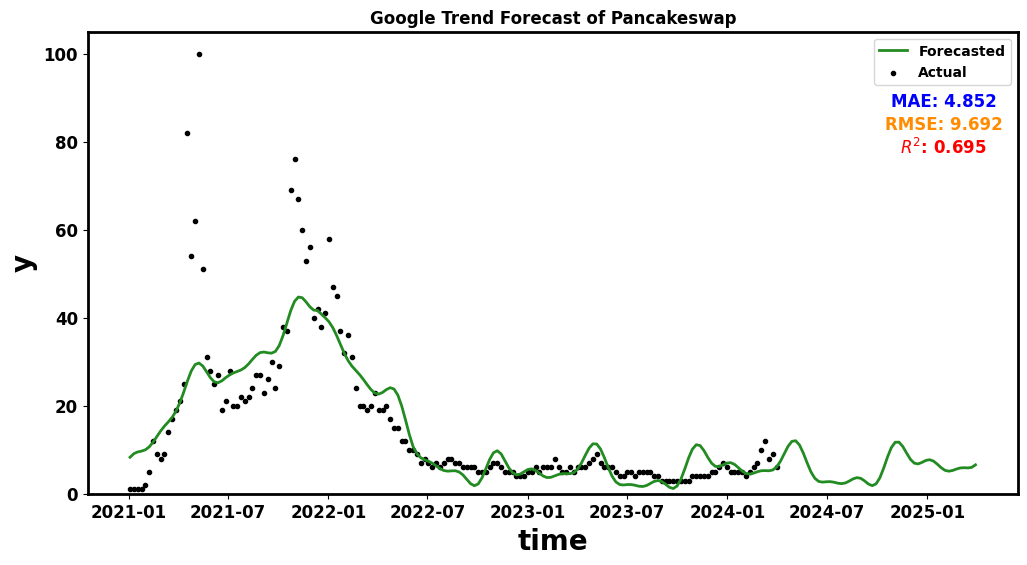

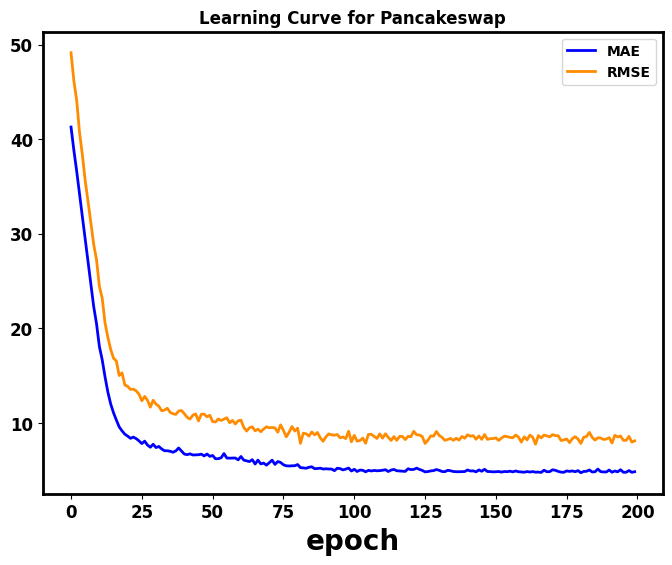

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 237.81it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 228.80it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_bnb.pkl.


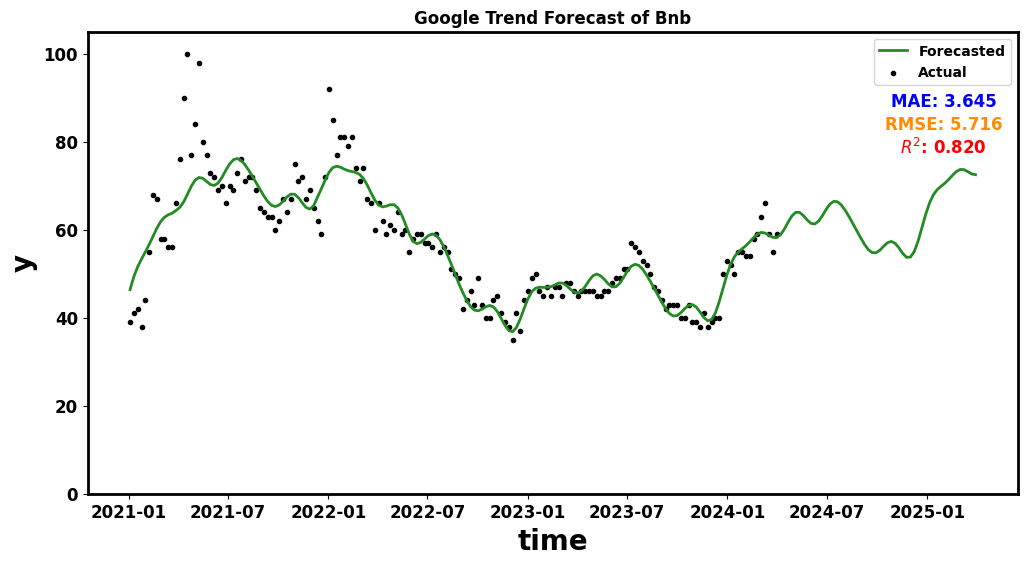

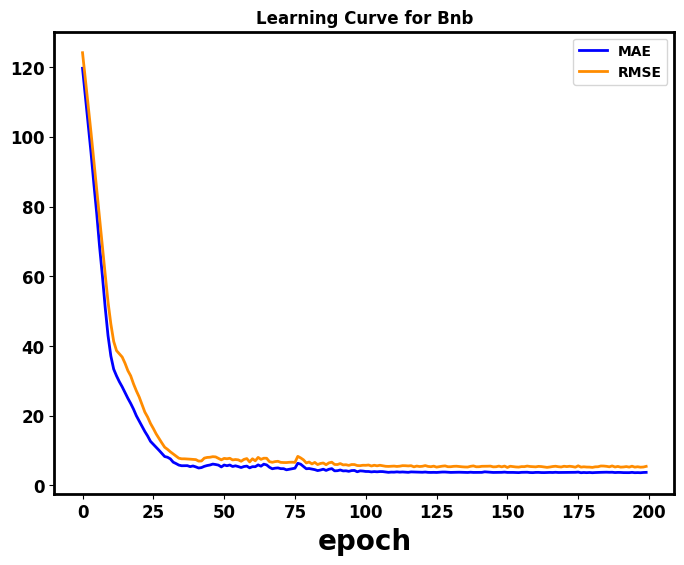

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 251.42it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 380.02it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_tezos.pkl.


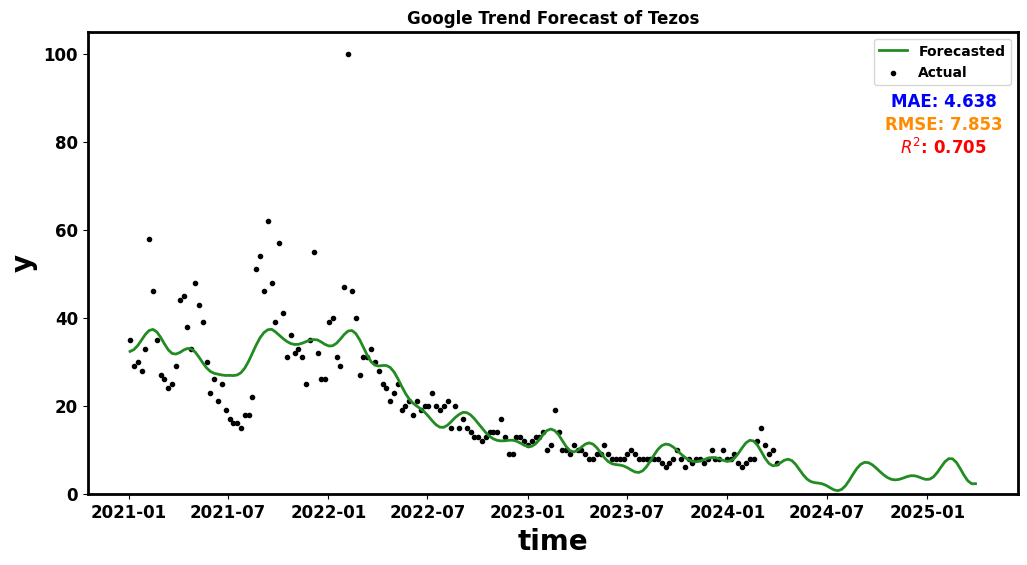

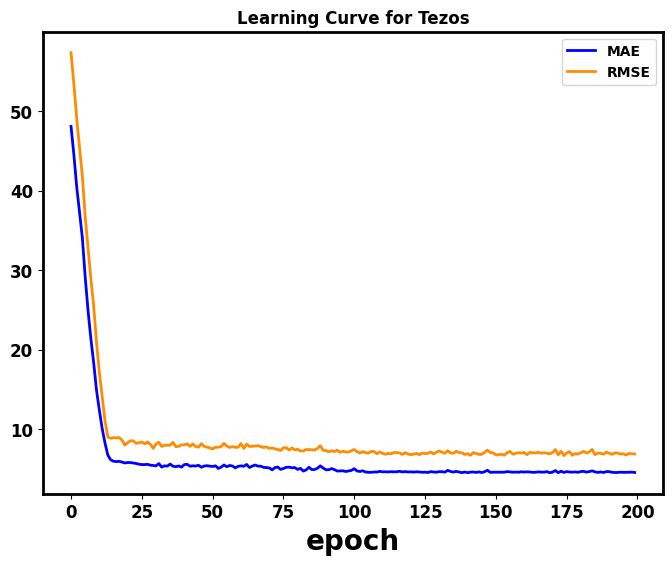

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 249.24it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 303.12it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_chainlink.pkl.


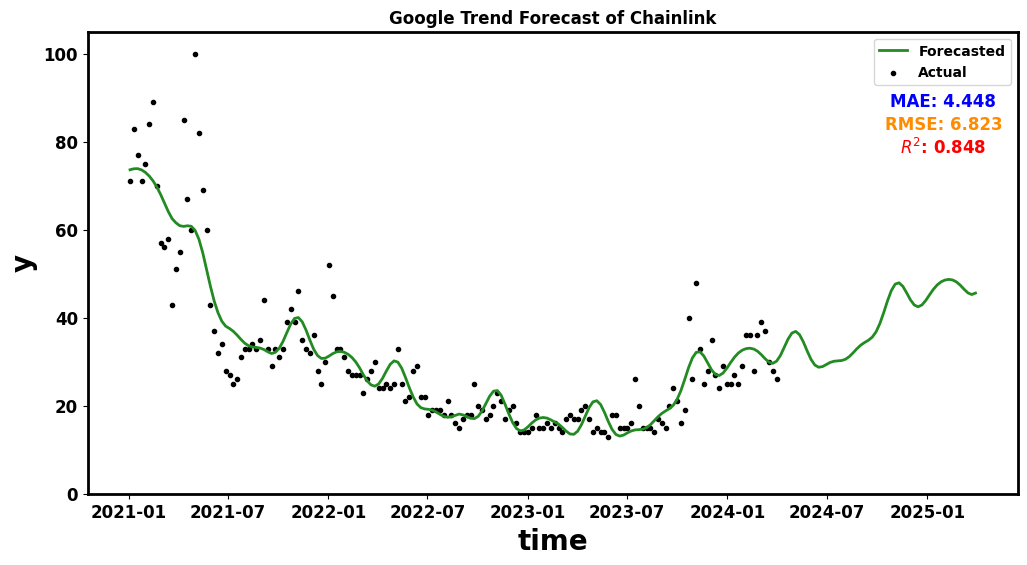

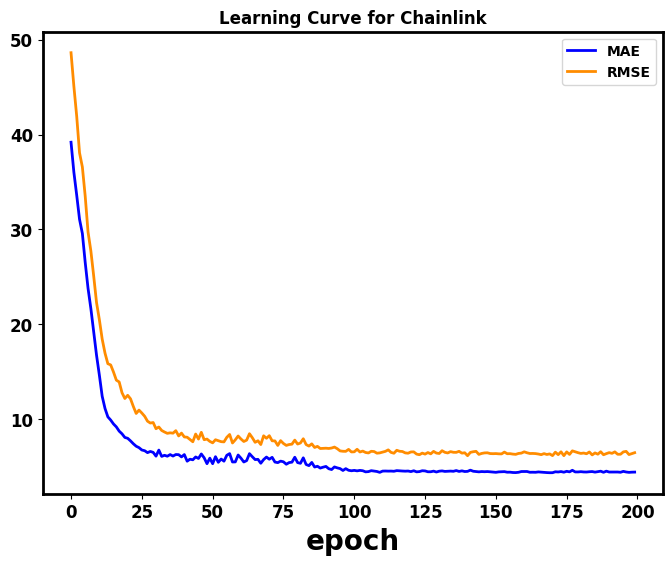

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 237.22it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 270.48it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_cardano.pkl.


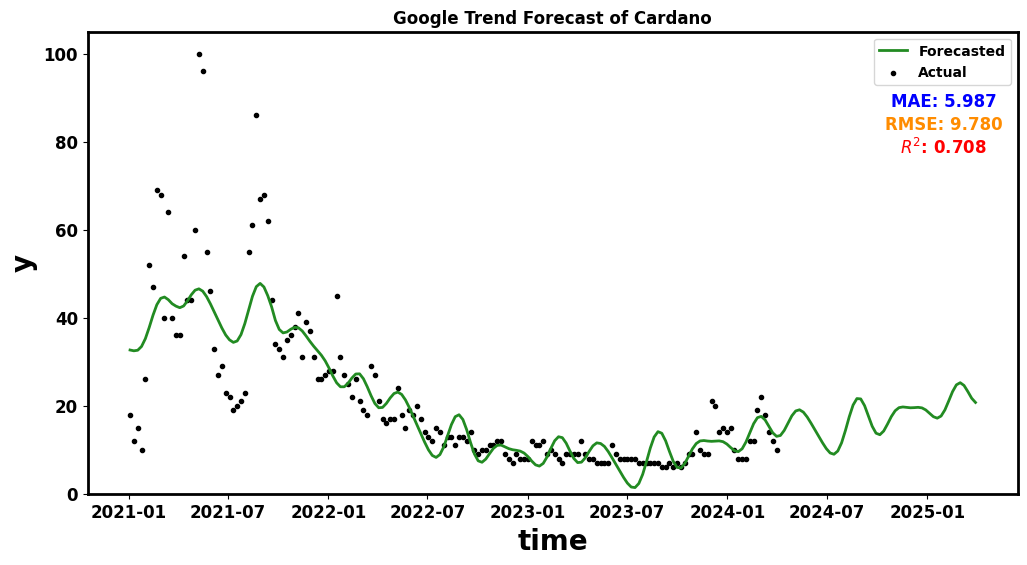

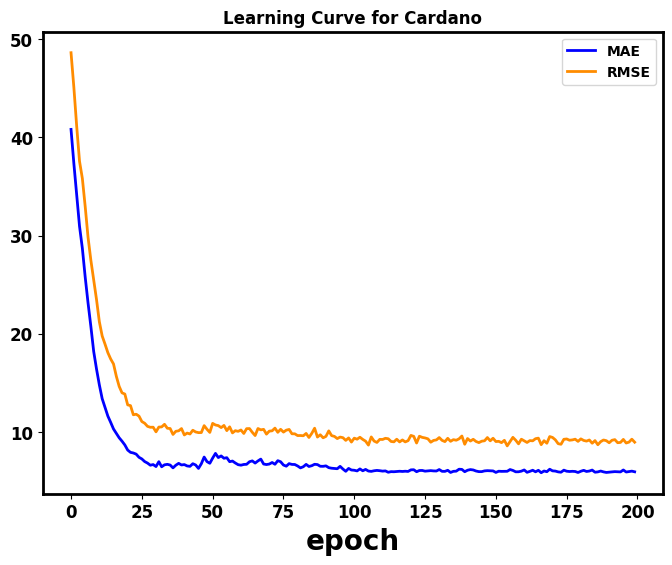

Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 273.66it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 292.71it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m0_solana.pkl.


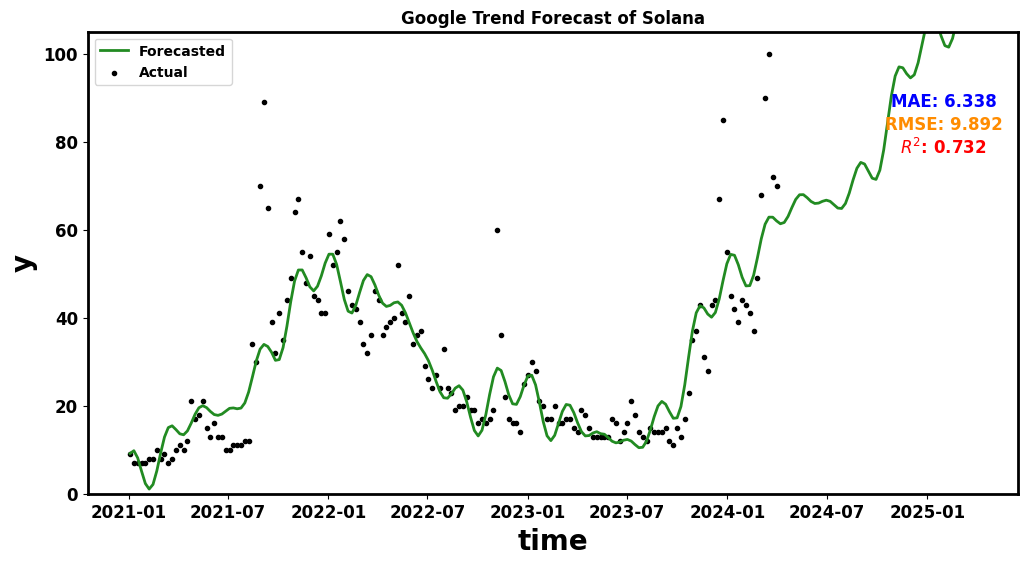

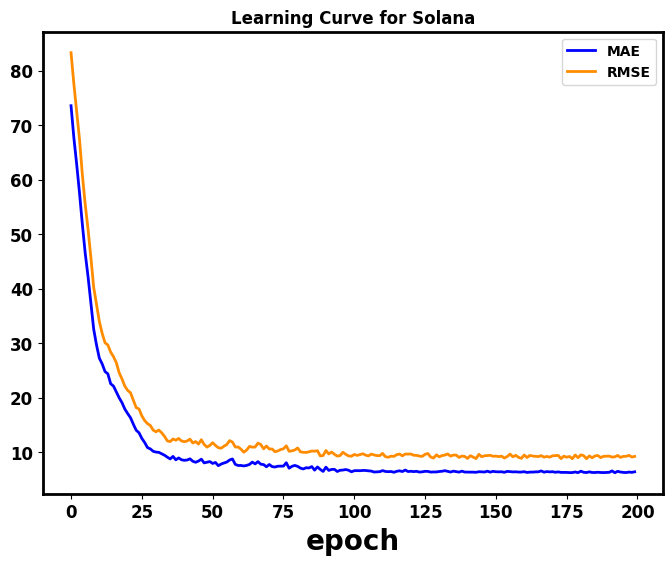

In [112]:
for c in namelist :
    naming = 'm0'
    df =  combined_df_dict[c][['Start_Date','count']]
    df.columns = ['ds','y']
    # Create a NeuralProphet model with default parameters
    m0 = NeuralProphet() # Always initialize to avoid fitted model refitted.
    model = m0
    future_duration = 52 # 52 weeks or a Year
    result = deploy_predict(model, df,future_duration)

    # Save result right away
    filepath = f'/home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/{naming}_{c}.pkl'
    filedict = result
    DC.save_dict(filepath,filedict)

    # Plot and save result
    Plot_data(result, c, naming)

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 252.14it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_polkadot.pkl.


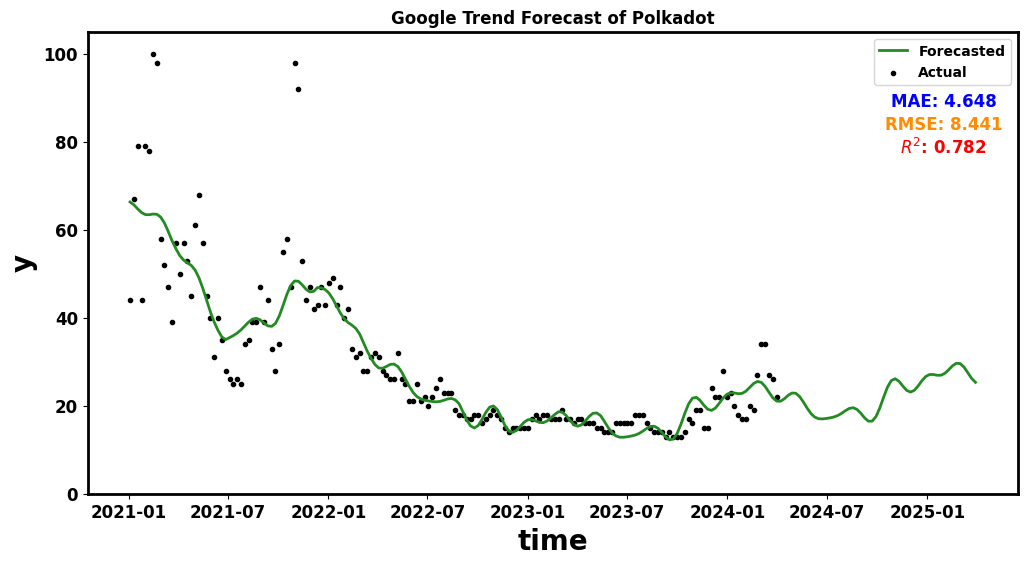

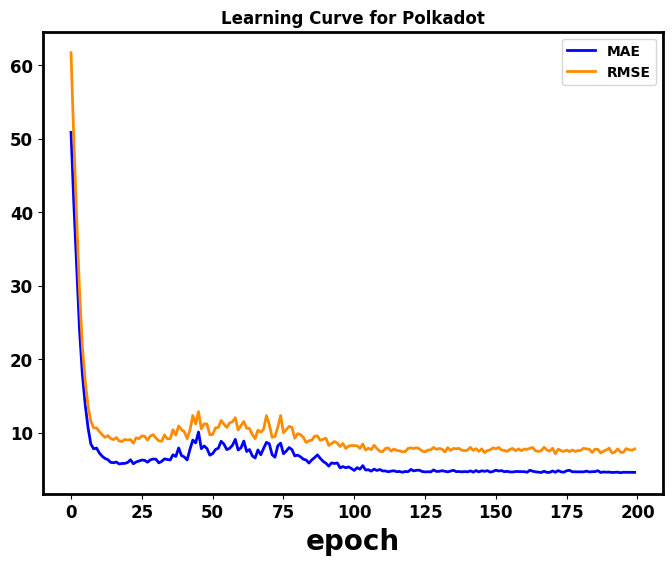

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 373.23it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_monero.pkl.


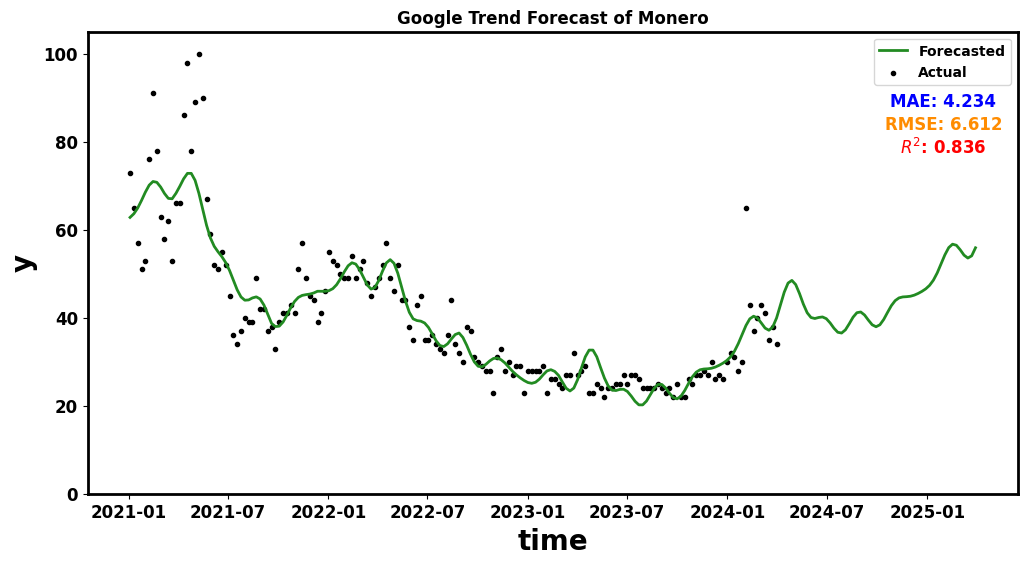

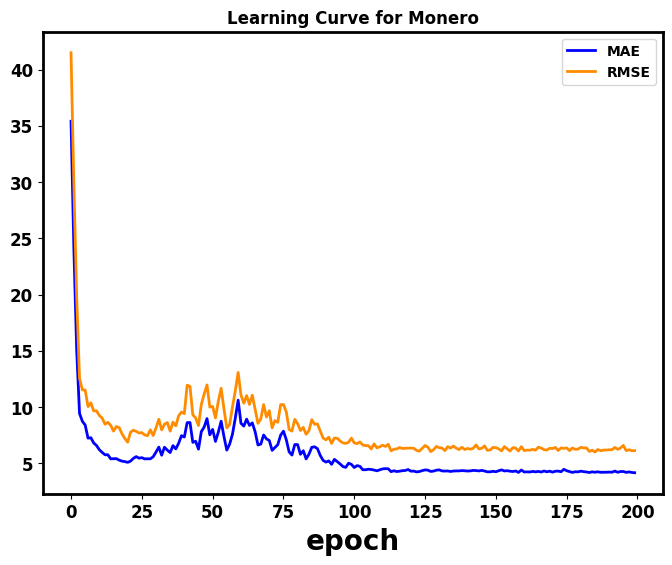

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 354.85it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_XRP.pkl.


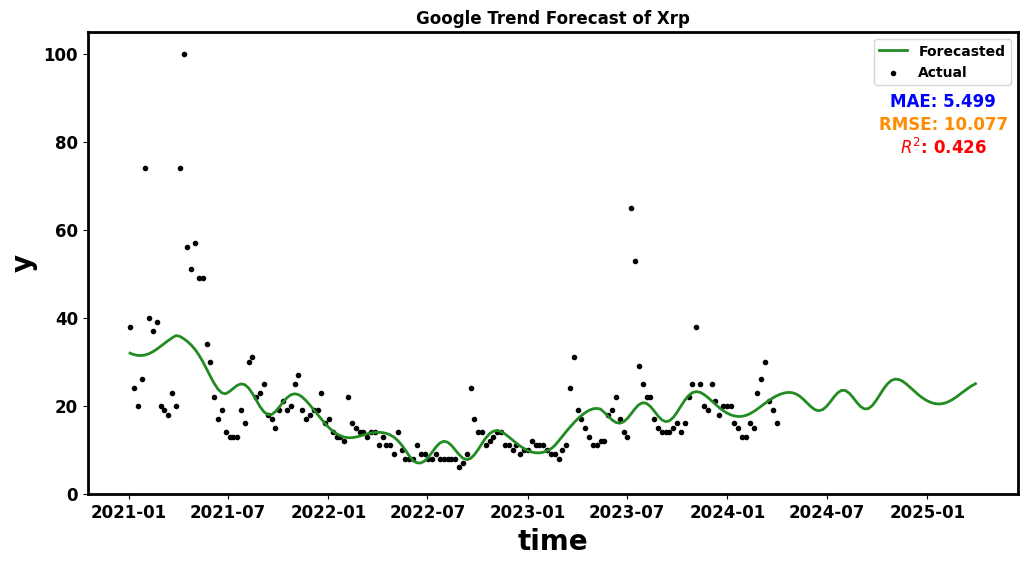

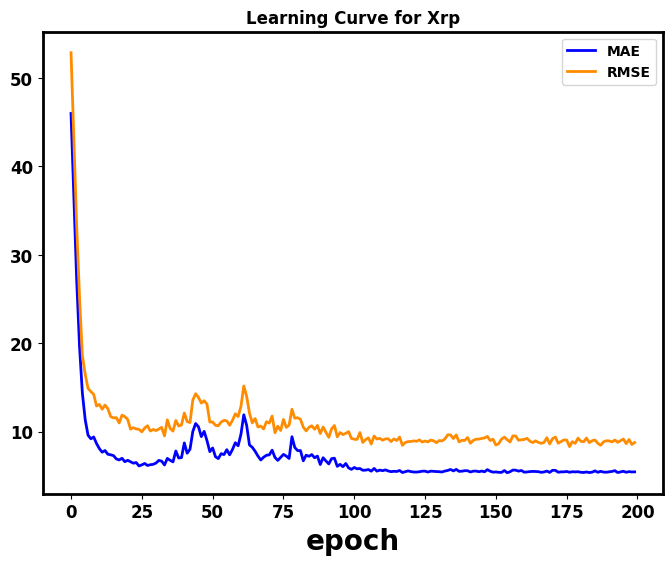

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 319.52it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_ethereum.pkl.


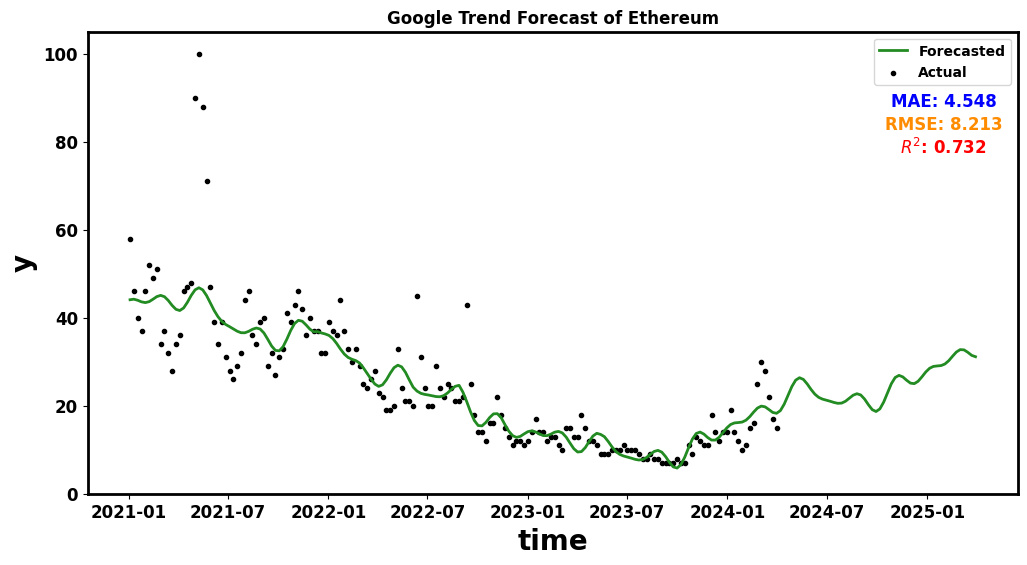

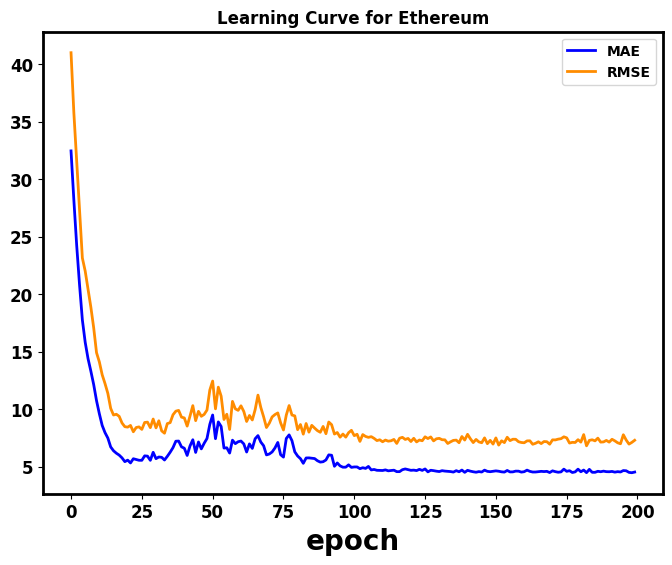

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 347.10it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_ocean protocol.pkl.


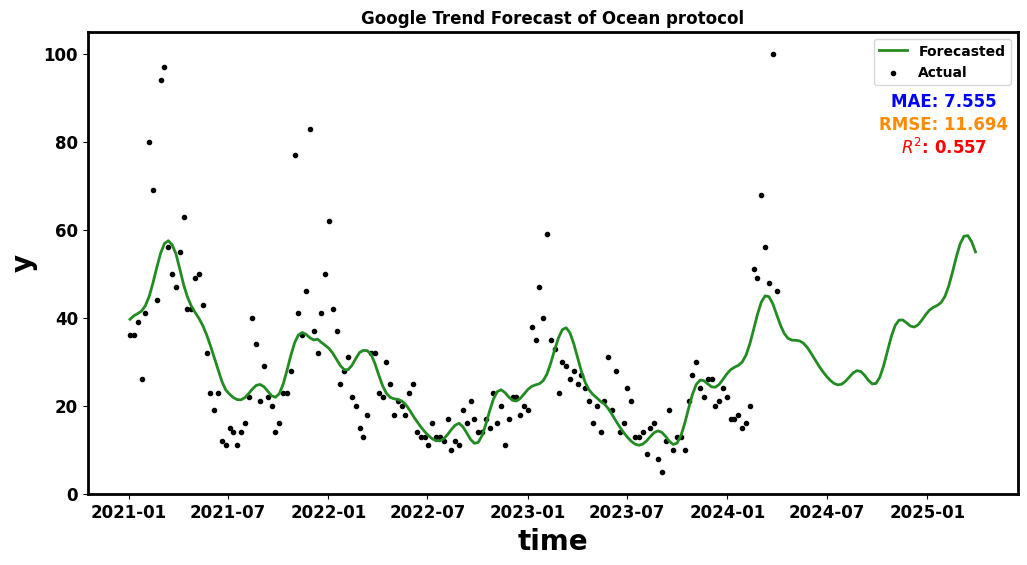

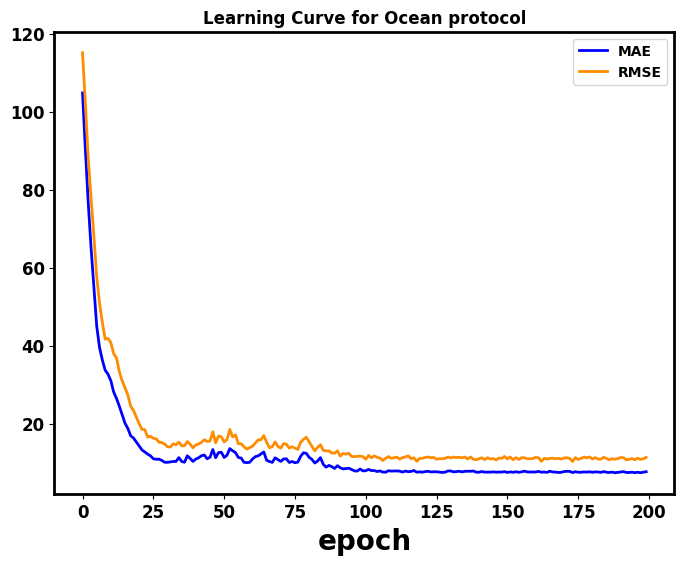

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 318.57it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_oasis network.pkl.


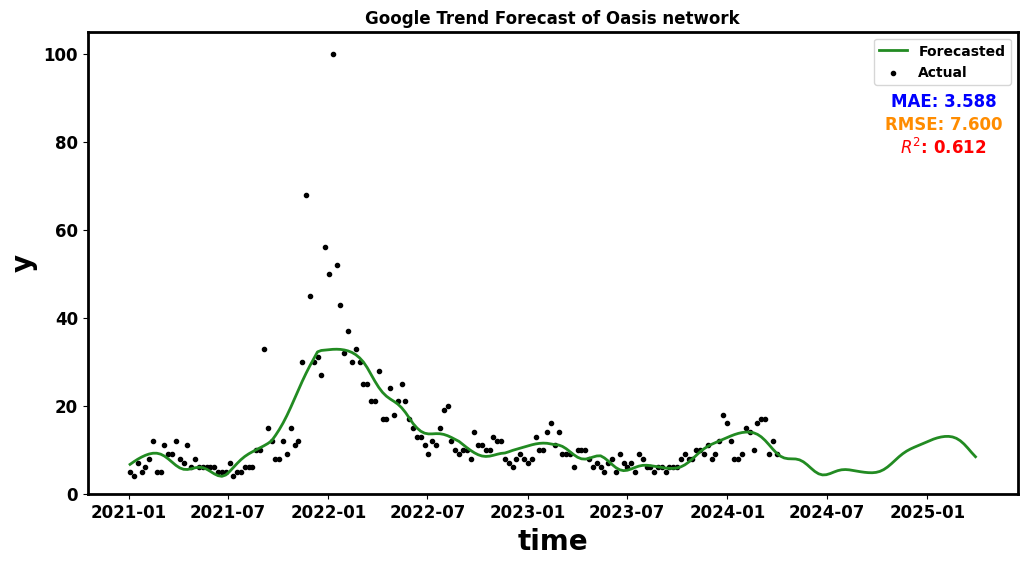

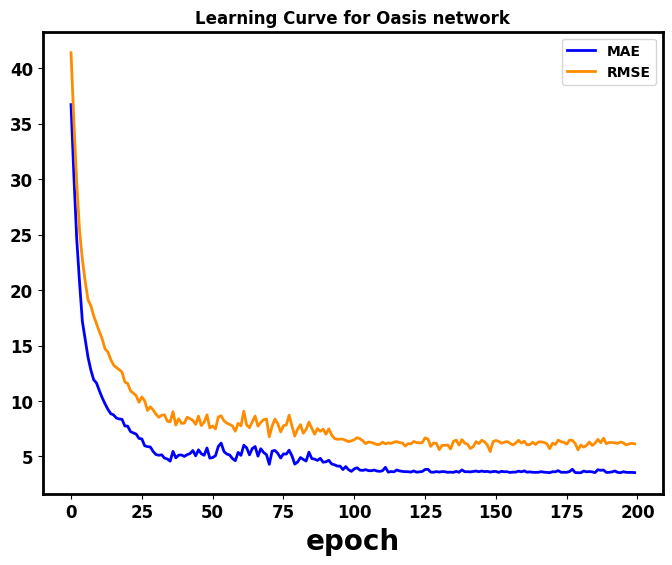

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.94it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_kucoin.pkl.


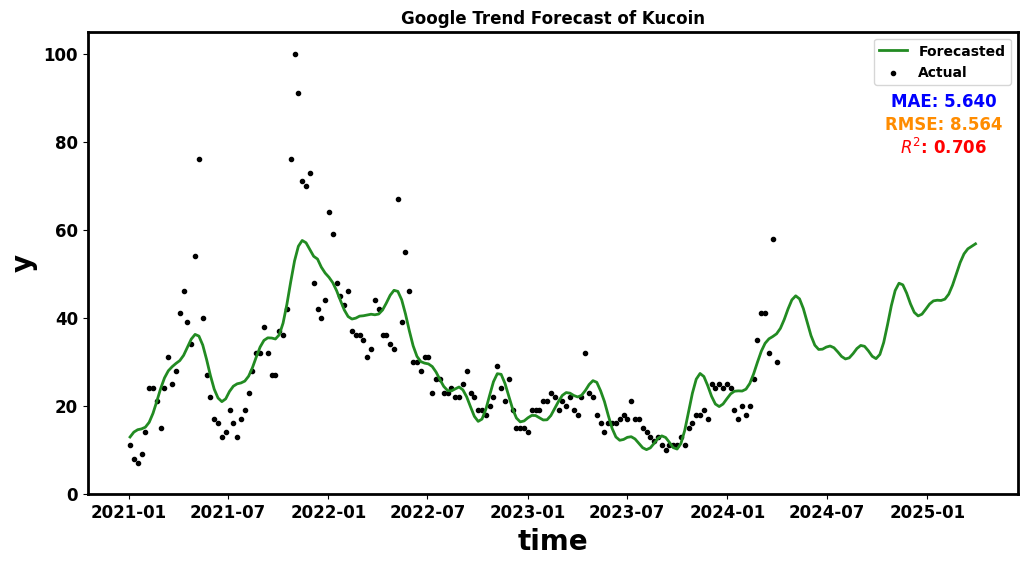

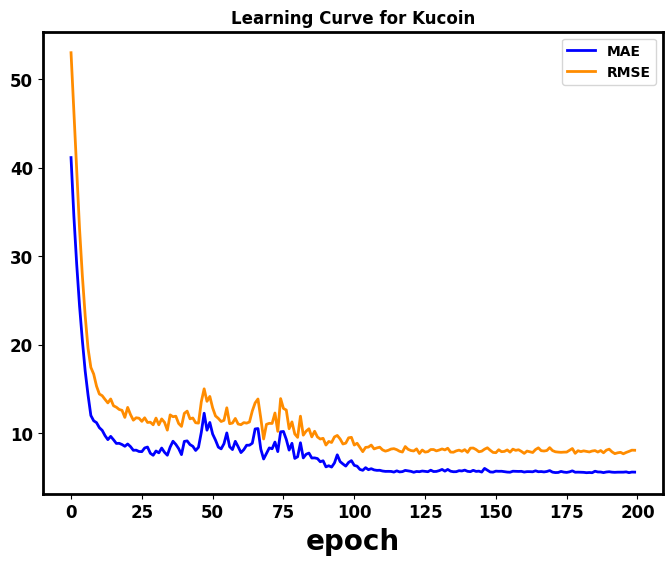

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 327.42it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_dogecoin.pkl.


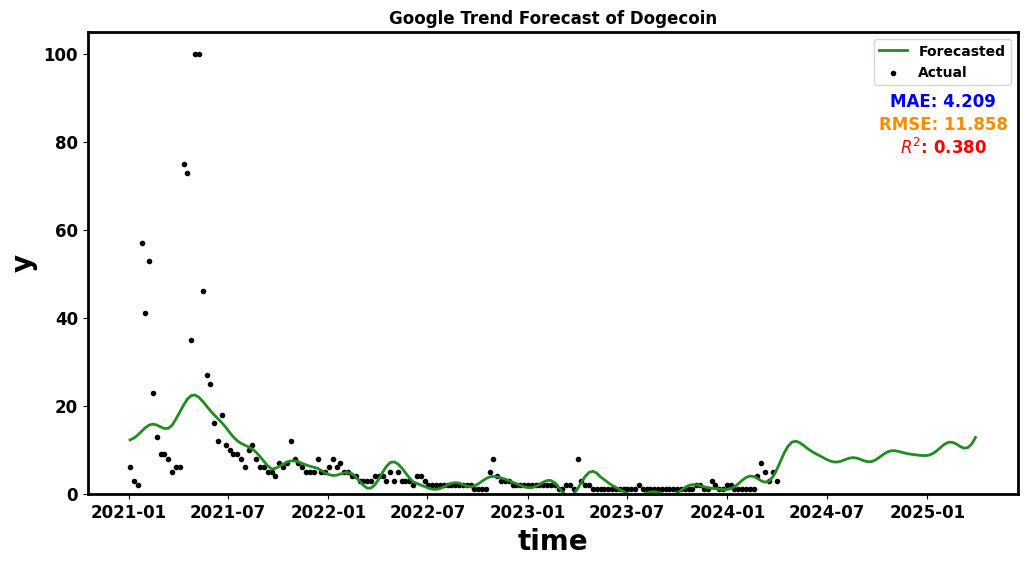

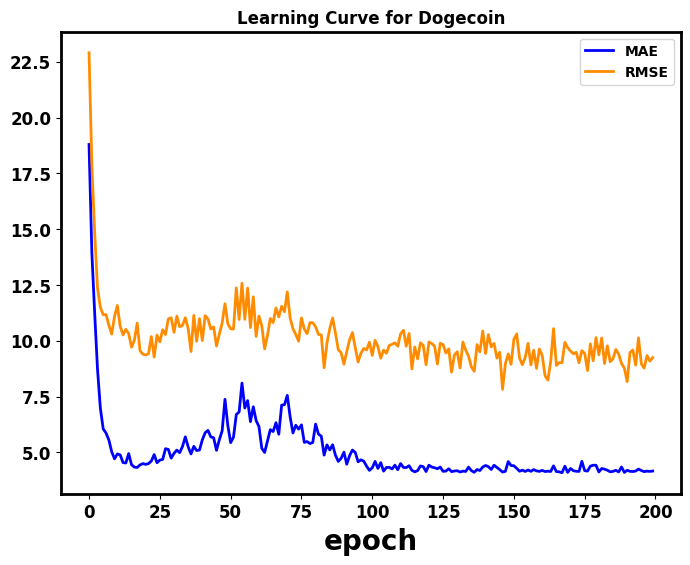

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 357.88it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_bitcoin.pkl.


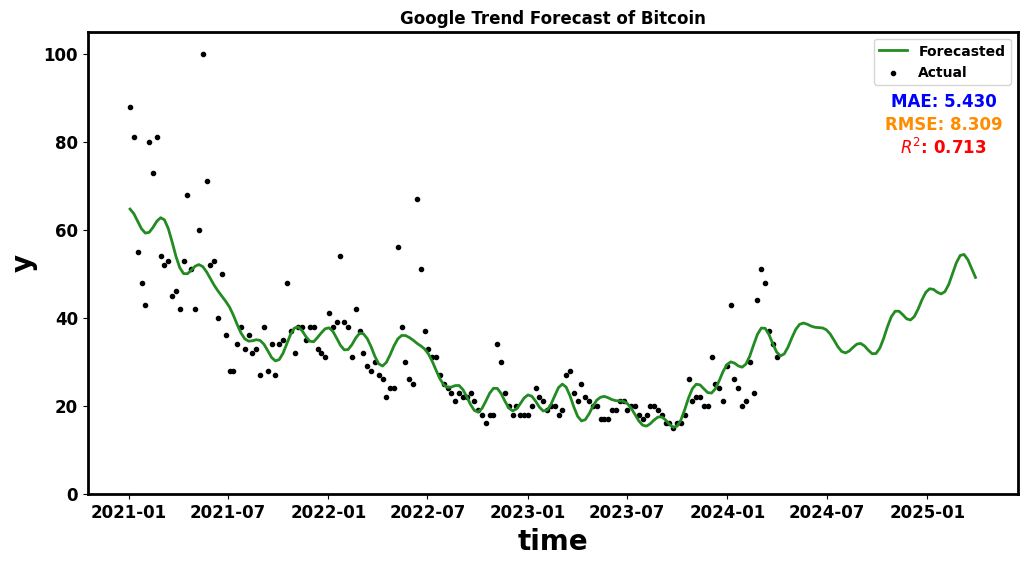

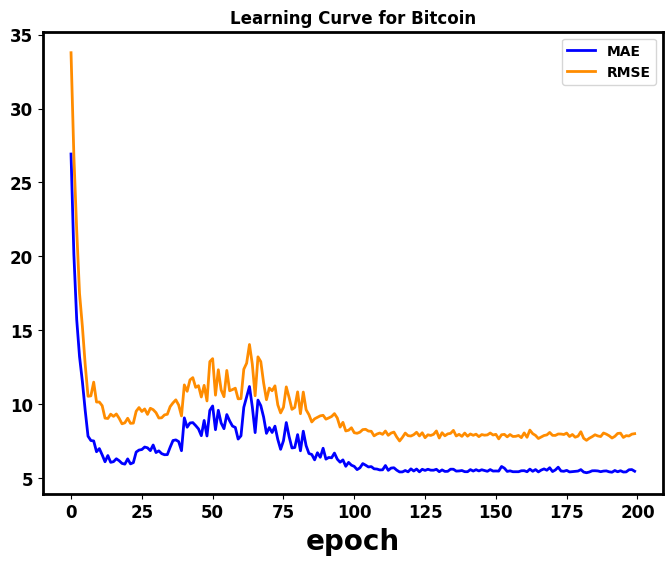

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 293.23it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_fetch.ai.pkl.


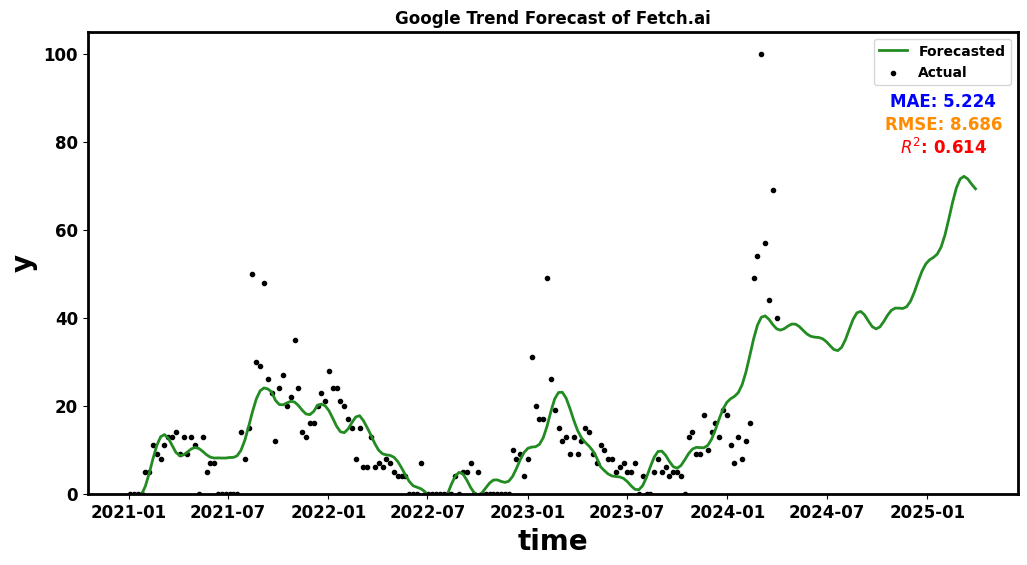

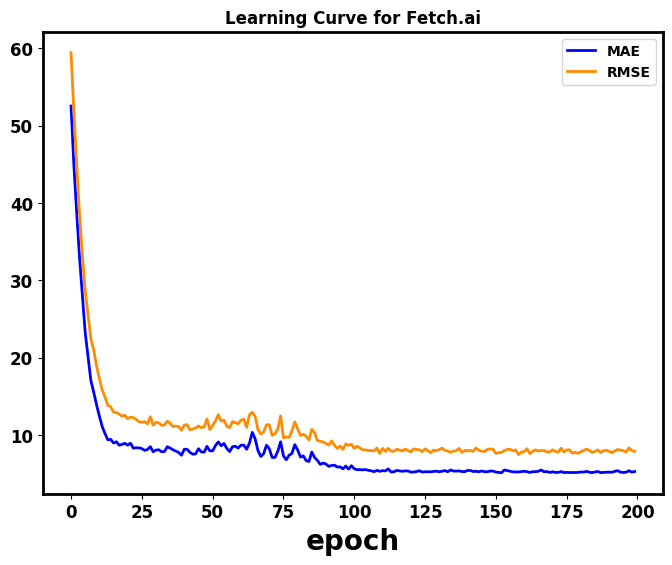

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 310.99it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_singularitynet.pkl.


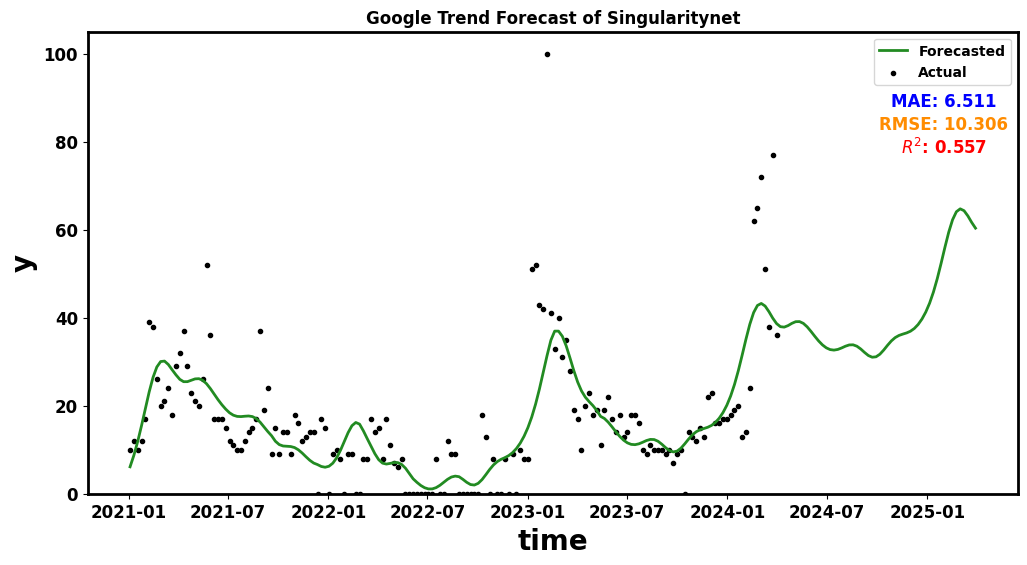

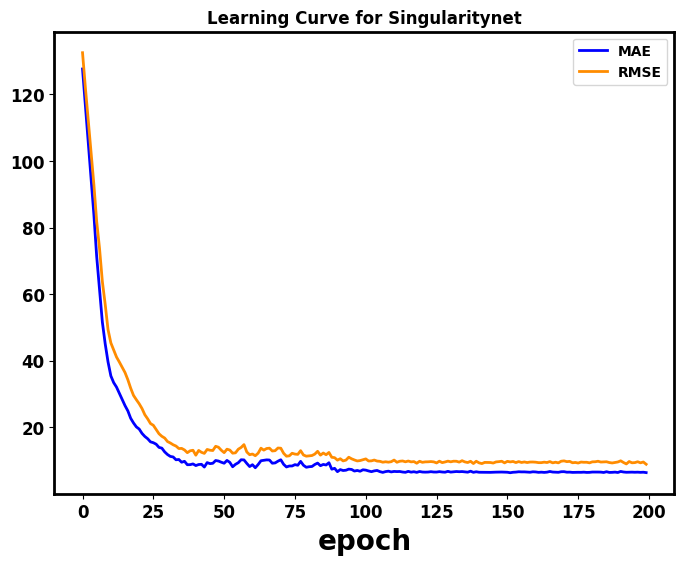

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 374.66it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_litecoin.pkl.


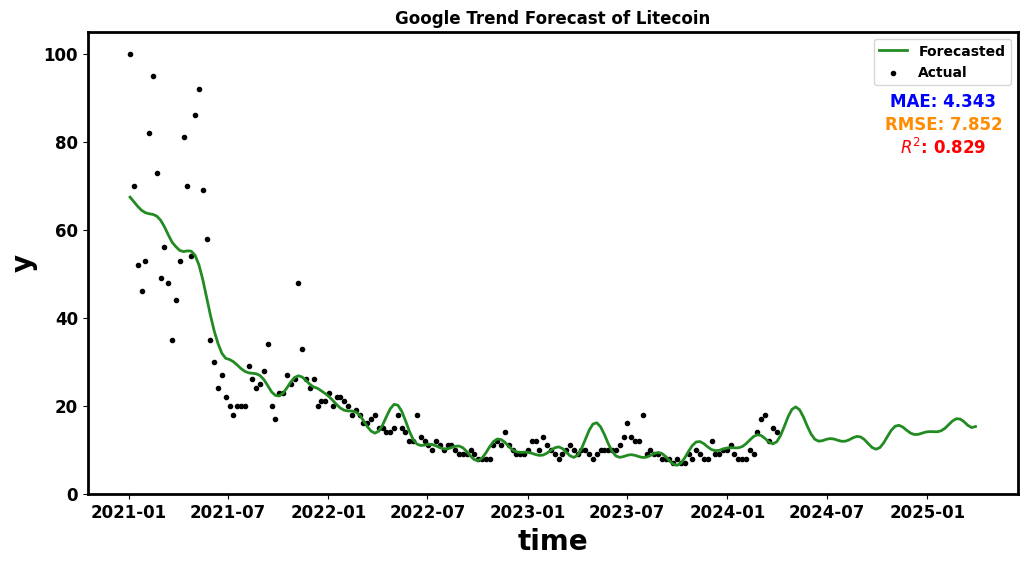

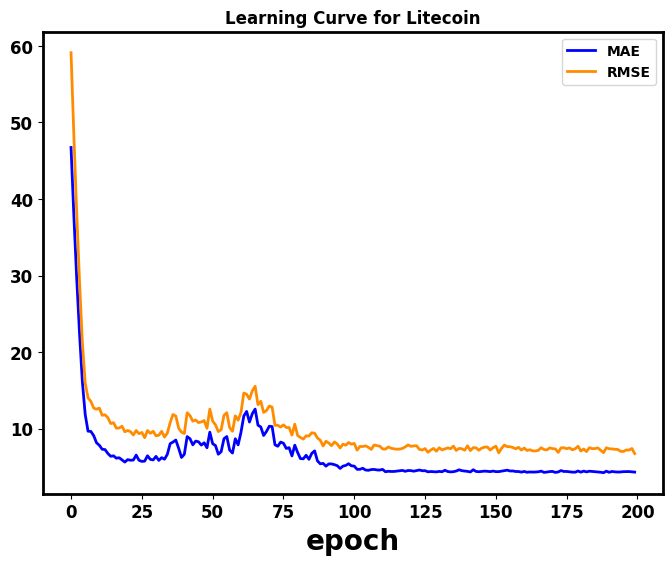

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 340.03it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_uniswap.pkl.


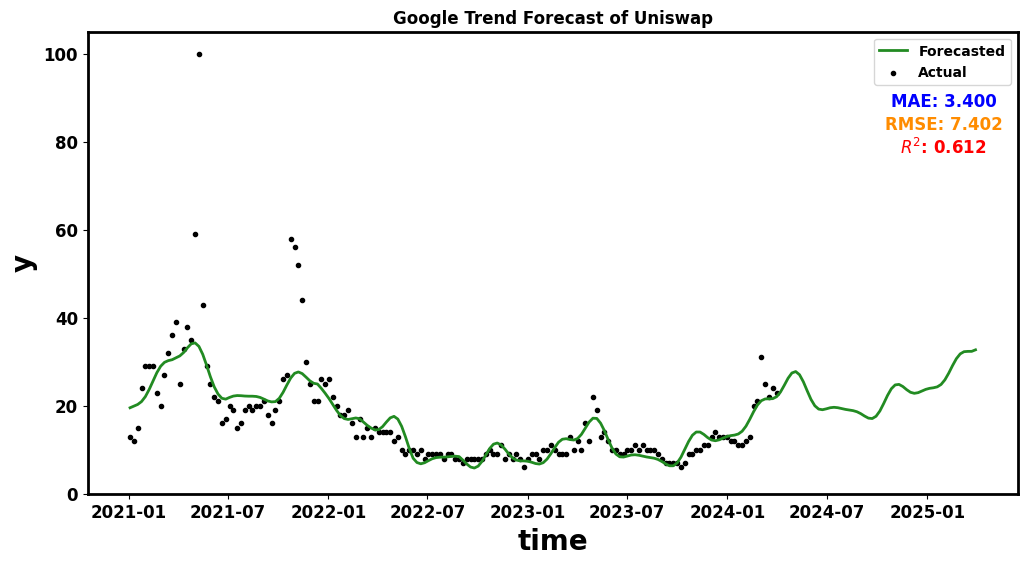

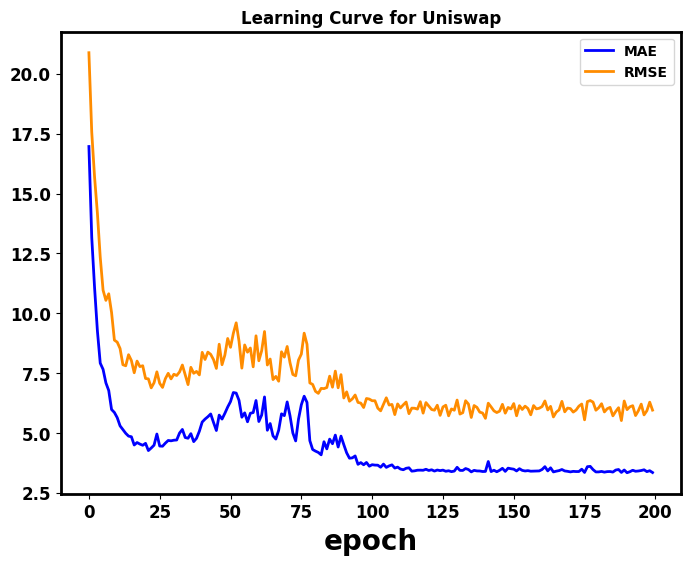

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 225.49it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_filecoin.pkl.


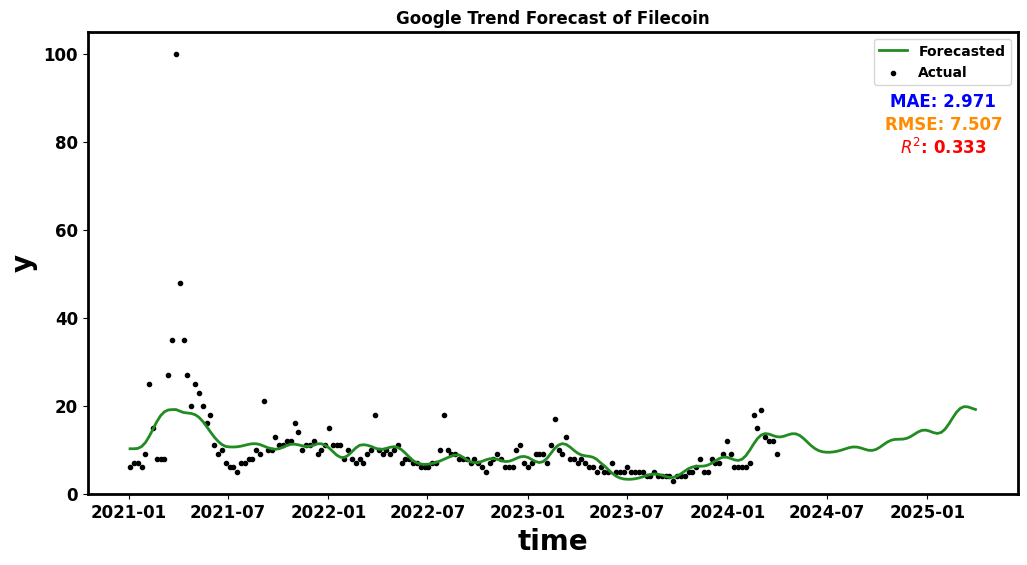

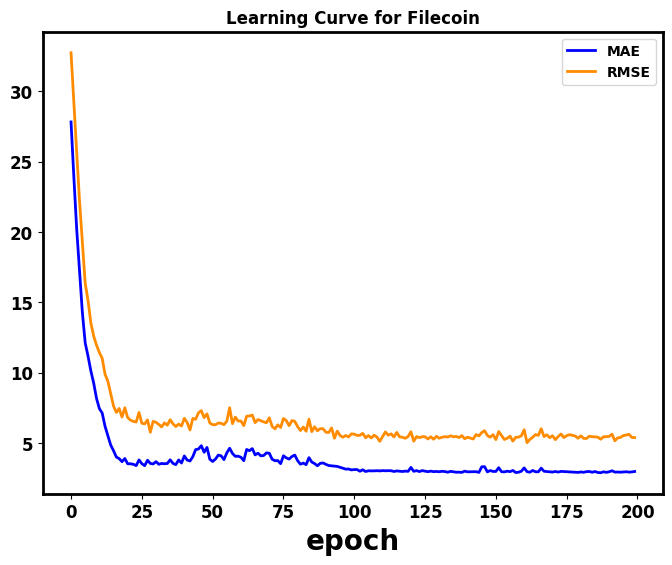

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 365.96it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_pancakeswap.pkl.


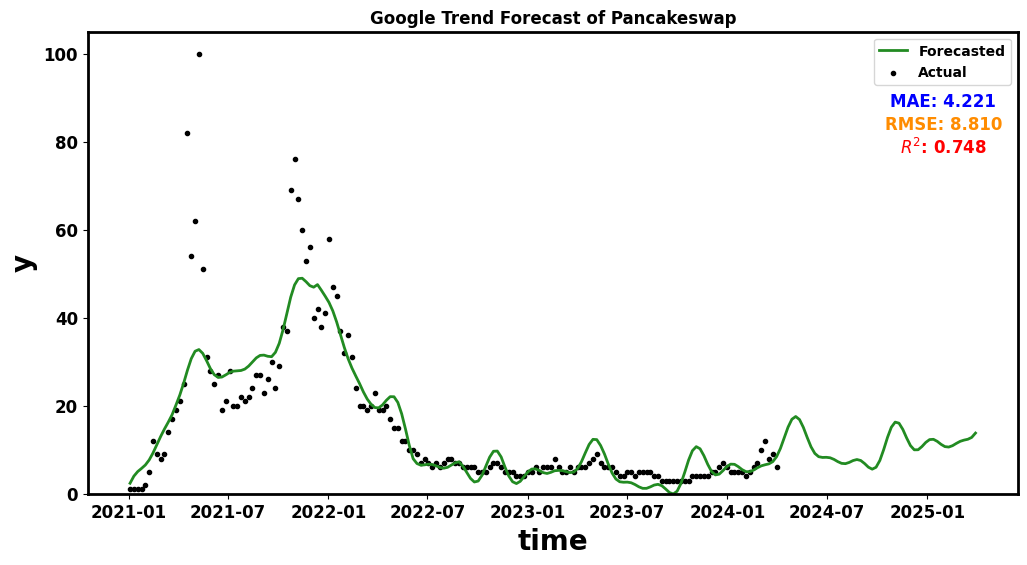

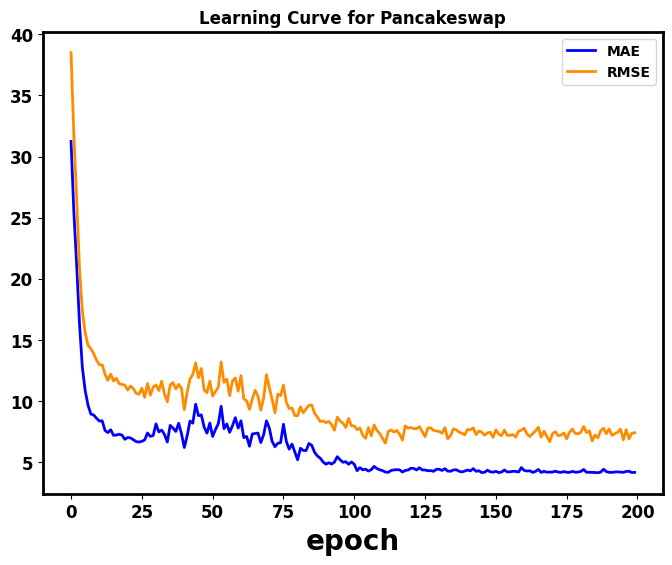

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 177.57it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_bnb.pkl.


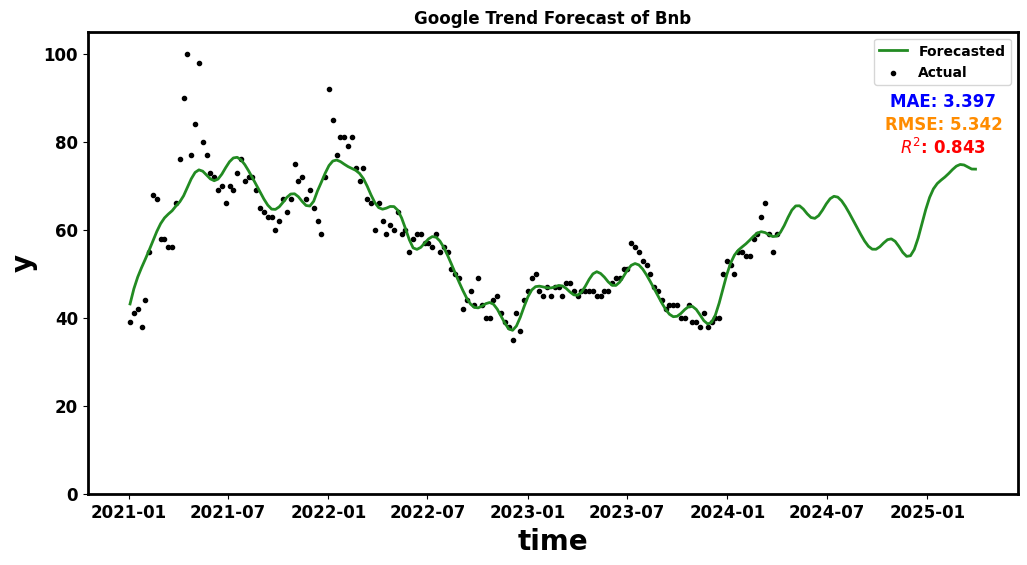

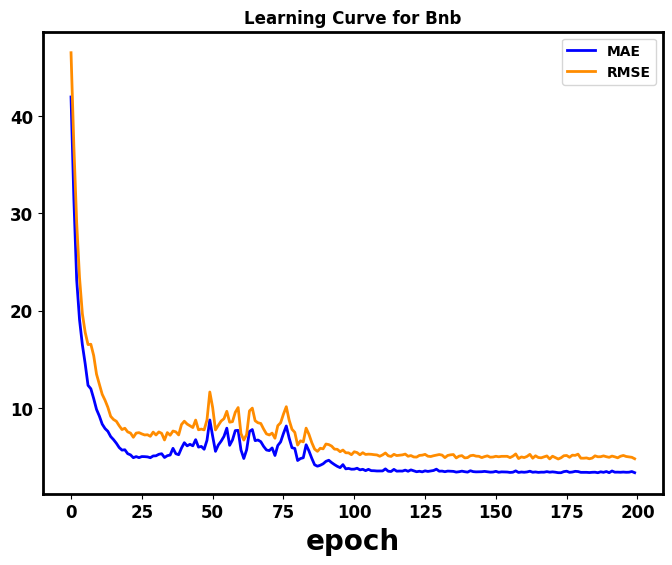

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 245.81it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_tezos.pkl.


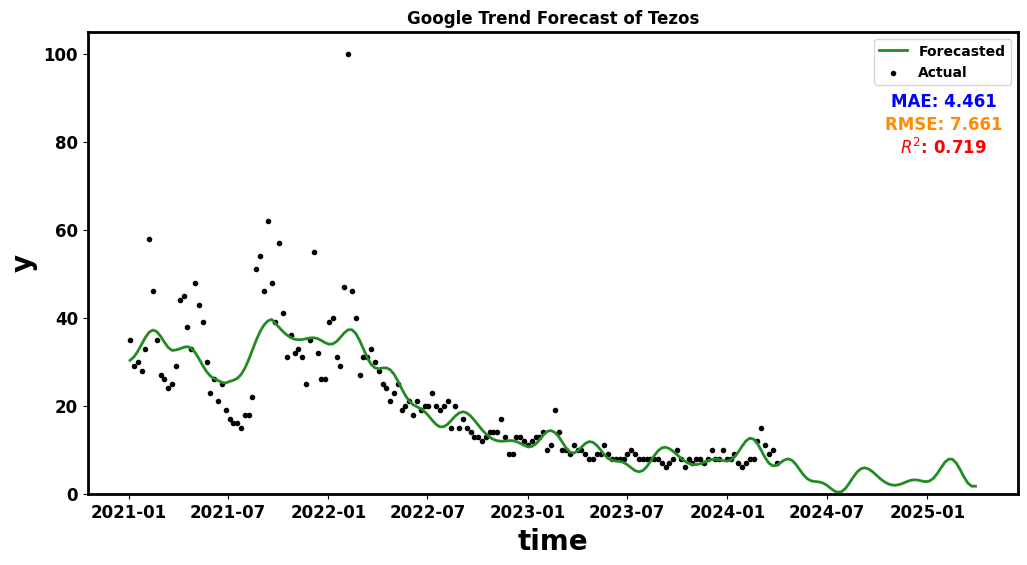

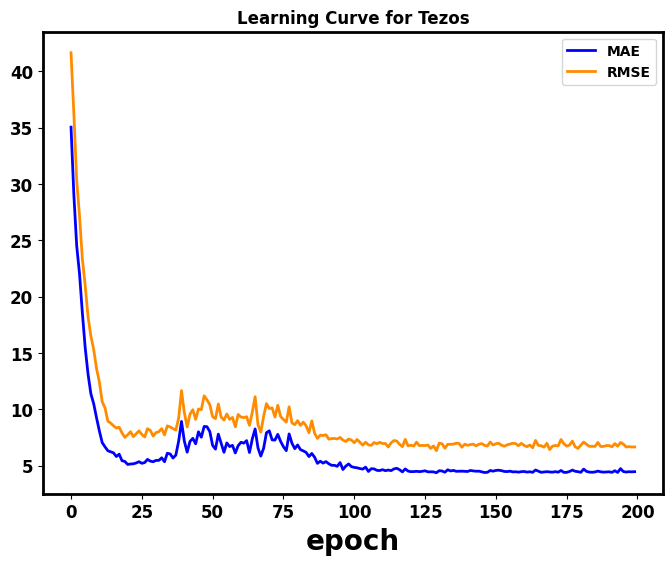

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 303.19it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_chainlink.pkl.


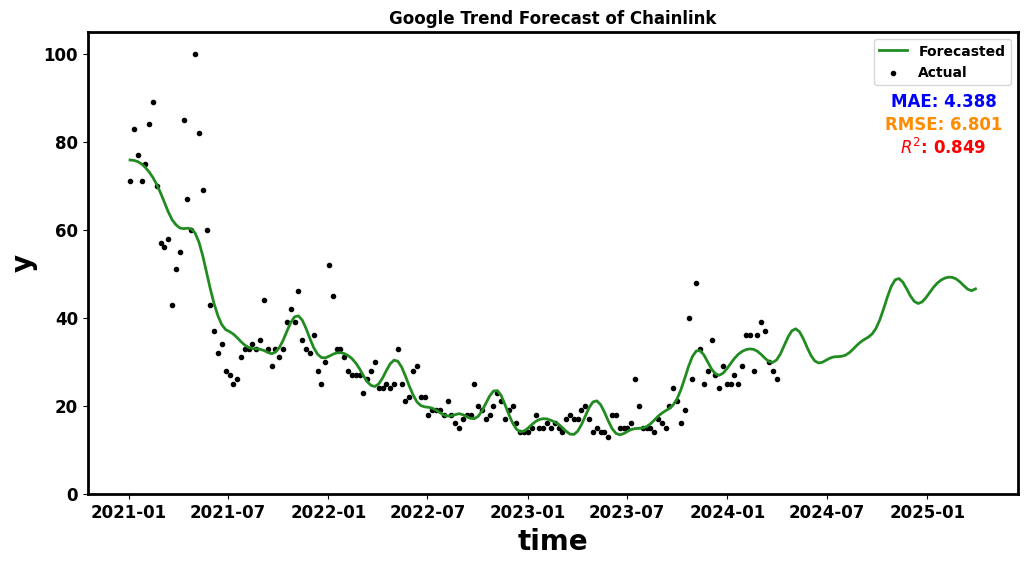

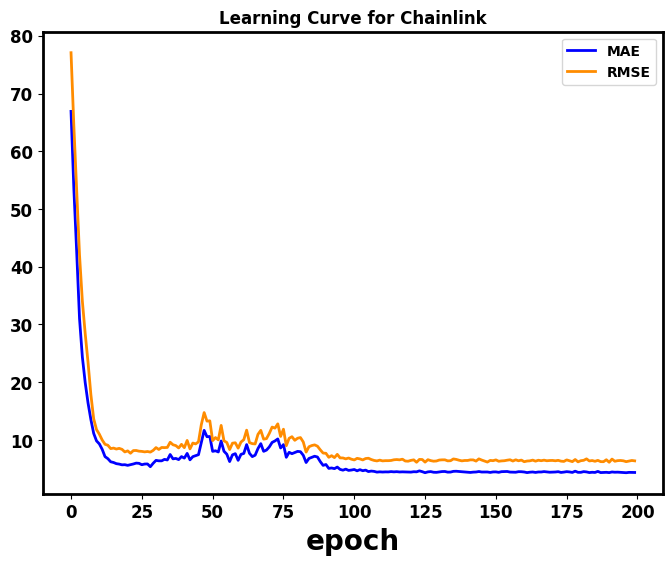

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 272.53it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_cardano.pkl.


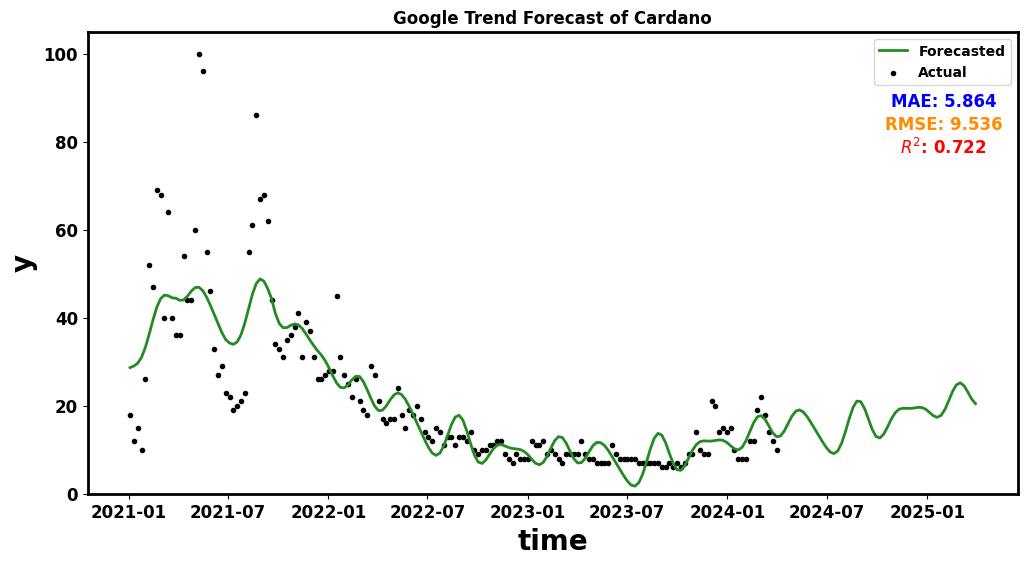

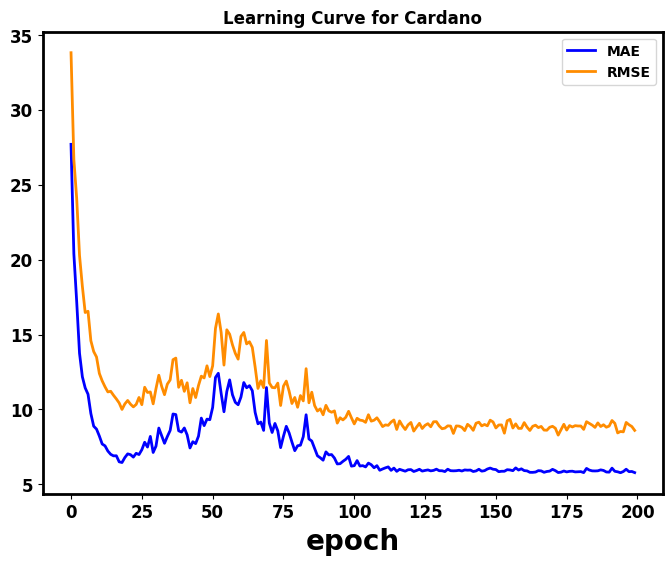

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 216.76it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_solana.pkl.


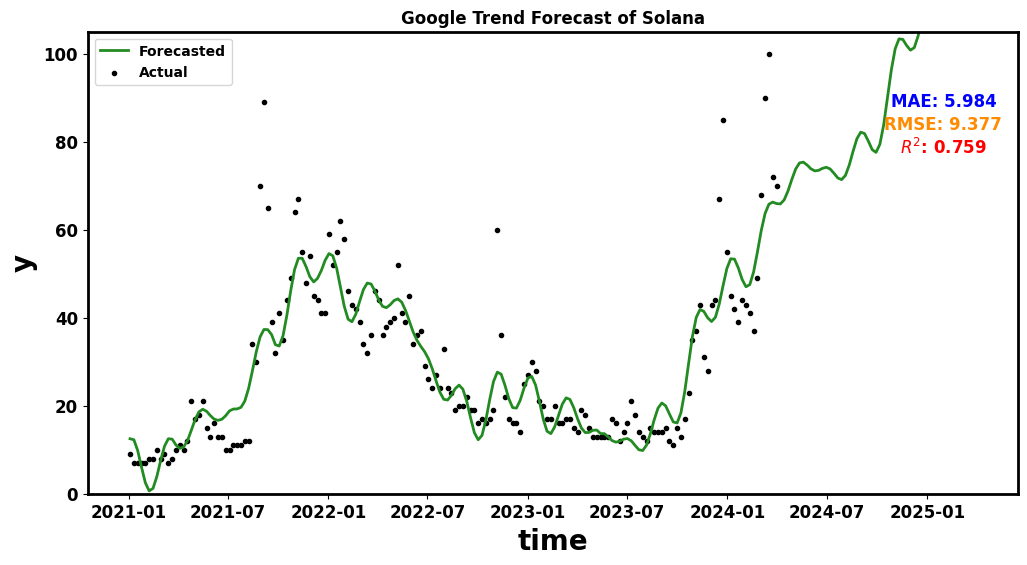

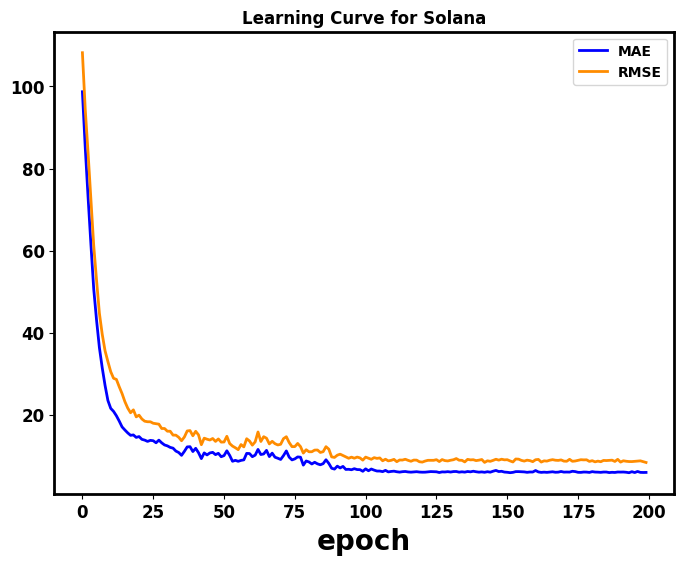

In [113]:
for c in namelist :
    naming = 'm1'
    df =  combined_df_dict[c][['Start_Date','count']]
    df.columns = ['ds','y']
    # Create a NeuralProphet model with default parameters
    m1 = NeuralProphet(
        optimizer='AdamW',
        learning_rate = 0.1
    )
    model = m1
    future_duration = 52 # 52 weeks or a Year
    result = deploy_predict(model, df,future_duration)

    # Save result right away
    filepath = f'/home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/{naming}_{c}.pkl'
    filedict = result
    DC.save_dict(filepath,filedict)

    # Plot and save result
    Plot_data(result, c, naming)

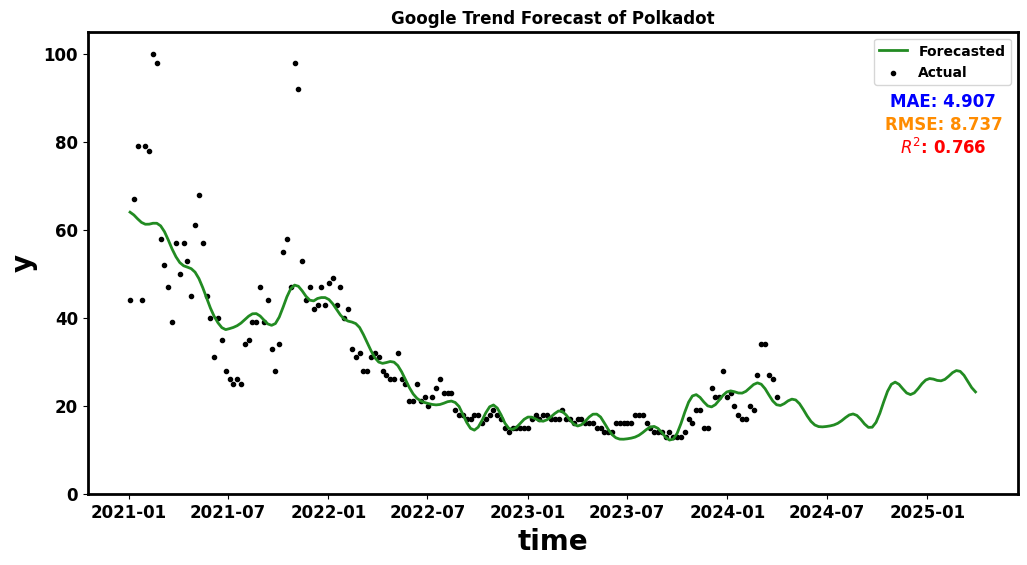

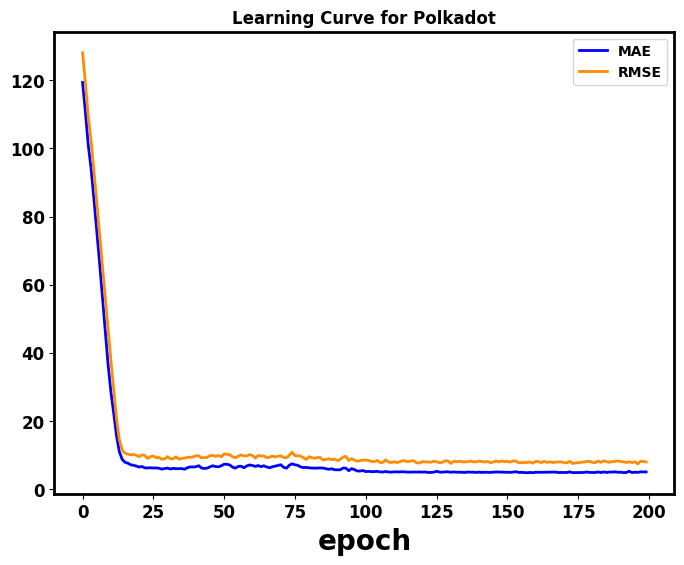

In [81]:
my_result = result_m0
c = 'polkadot'
Plot_data(my_result, c)

## M1 With AutoRegression


Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 276.65it/s]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 390.20it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_polkadot.pkl.


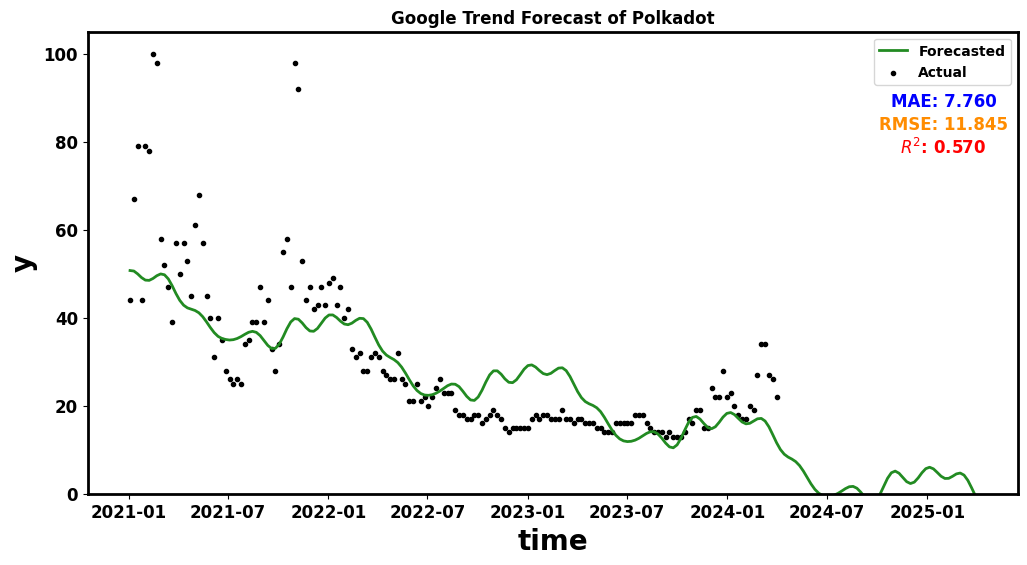

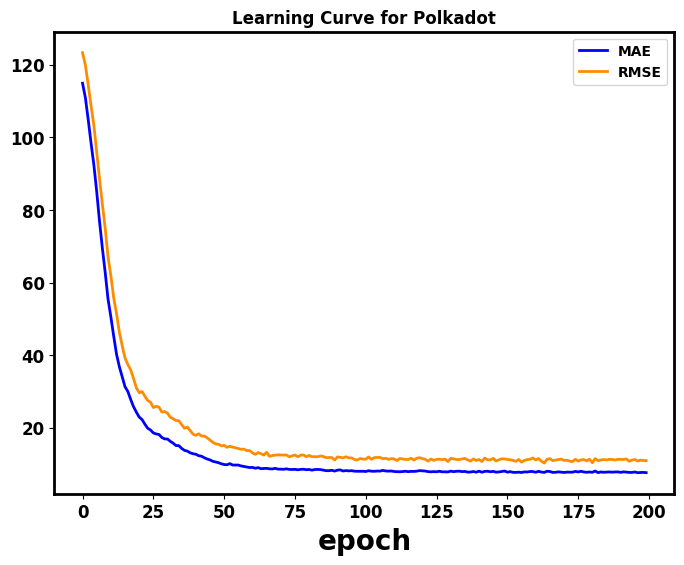

In [94]:
c = 'polkadot'
naming = 'm1'
df = mytrend
# Create a NeuralProphet model with default parameters
m1 = NeuralProphet(
    optimizer='SGD'
)
model = m1
future_duration = 52 # 52 weeks or a Year
result = deploy_predict(model, df,future_duration)

# Save result right away
filepath = f'/home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/{naming}_{c}.pkl'
filedict = result
DC.save_dict(filepath,filedict)

# Plot and save result
Plot_data(result, c, naming)

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 317.22it/s]
The dict data has been saved to /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/m1_polkadot.pkl.


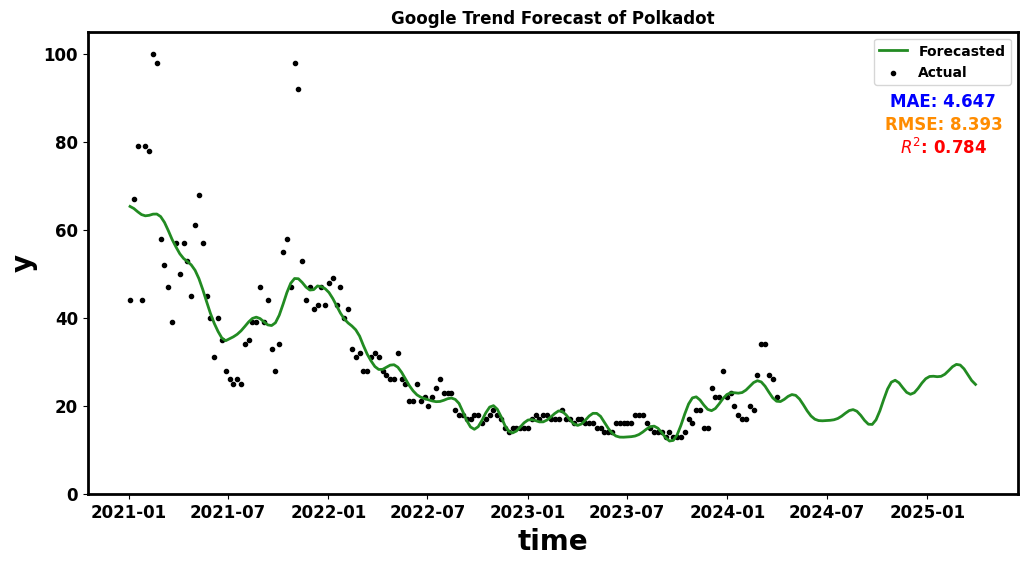

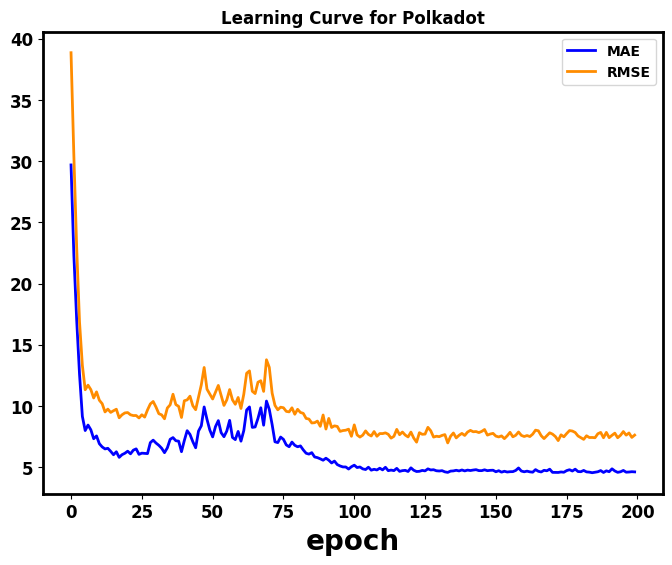

In [100]:
c = 'polkadot'
naming = 'm1'
df = mytrend
# Create a NeuralProphet model with default parameters
m1 = NeuralProphet(
    optimizer='AdamW',
    learning_rate = 0.1
)
model = m1
future_duration = 52 # 52 weeks or a Year
result = deploy_predict(model, df,future_duration)

# Save result right away
filepath = f'/home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/results/Forecast_models/{naming}_{c}.pkl'
filedict = result
DC.save_dict(filepath,filedict)

# Plot and save result
Plot_data(result, c, naming)

In [ ]:
## Full deployment

## Tutorial Example

## Neural Prophet

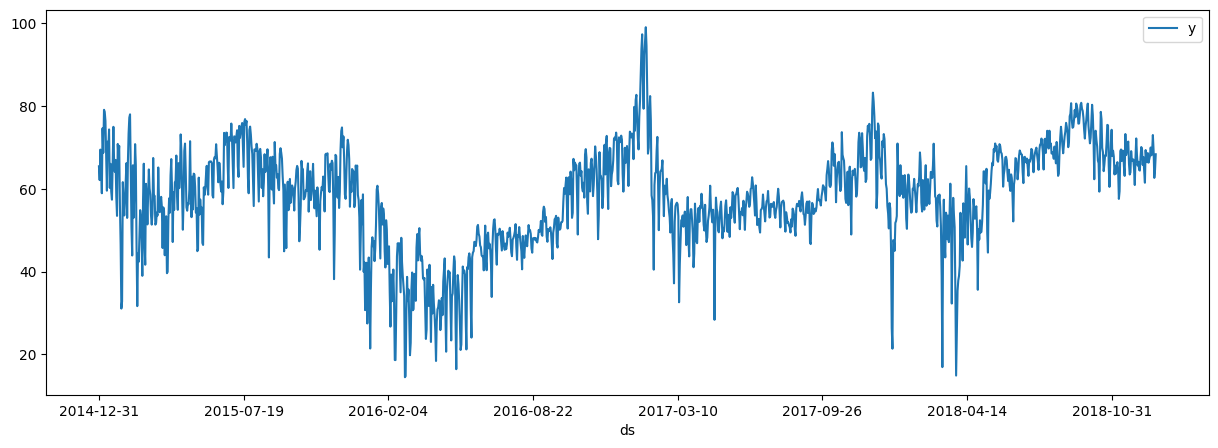

In [2]:
import pandas as pd

# Load the dataset from the CSV file using pandas
df = pd.read_csv("https://github.com/ourownstory/neuralprophet-data/raw/main/kaggle-energy/datasets/tutorial01.csv")
# Plot the dataset, showing price (y column) over time (ds column)
plt = df.plot(x="ds", y="y", figsize=(15, 5))

In [3]:


# Disable logging messages unless there is an error
set_log_level("ERROR")

# Create a NeuralProphet model with default parameters
m = NeuralProphet()
# Use static plotly in notebooks
m.set_plotting_backend("plotly-static")

# Fit the model on the dataset (this might take a bit)
metrics = m.fit(df)

/root/anaconda3/envs/DreamBrookPy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
WARNING - (py.warnings._showwarnmsg) - /root/anaconda3/envs/DreamBrookPy/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

Missing logger folder: /home/Lakehouse/Competition/4_GoogleCryptoTrend_28Apr/notebook/lightning_logs
Finding best initial lr: 100%|████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 236.50it/s]
2024-04-30 01:55:04.933500: I t

Epoch 100: 100%|█████████████████| 100/100 [00:00<00:00, 494.71it/s, loss=0.0131, v_num=0, MAE=4.520, RMSE=6.160, Loss=0.0126, RegLoss=0.000]


In [8]:
# Create a new dataframe reaching 365 into the future for our forecast, n_historic_predictions also shows historic data
df_future = m.make_future_dataframe(df, n_historic_predictions=True, periods=365)

# Predict the future
forecast = m.predict(df_future)

# # Visualize the forecast
# m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /root/anaconda3/envs/DreamBrookPy/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /root/anaconda3/envs/DreamBrookPy/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /root/anaconda3/envs/DreamBrookPy/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /root/anaconda3/envs/DreamBrookPy/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning:

The behavior of DataFrame conc

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 264.01it/s]


In [9]:
forecast

ds      y      yhat1      trend  season_yearly  season_weekly
0    2014-12-31  65.41  66.495461  64.272438       0.383592       1.839426
1    2015-01-01  62.09  66.493080  64.279739       0.256318       1.957021
2    2015-01-02  69.44  66.050774  64.287041       0.143331       1.620405
3    2015-01-03  65.22  61.306602  64.294334       0.045308      -3.033037
4    2015-01-04  58.91  58.253319  64.301628      -0.038215      -6.010096
...         ...    ...        ...        ...            ...            ...
1822 2019-12-27    NaN  73.683563  70.980568       1.079430       1.623563
1823 2019-12-28    NaN  68.858559  70.993828       0.894880      -3.030152
1824 2019-12-29    NaN  65.717598  71.007088       0.722264      -6.011761
1825 2019-12-30    NaN  73.145653  71.020355       0.563268       1.562034
1826 2019-12-31    NaN  73.520180  71.033615       0.417770       2.068791

[1827 rows x 6 columns]

Text(0.5, 0, 'time')

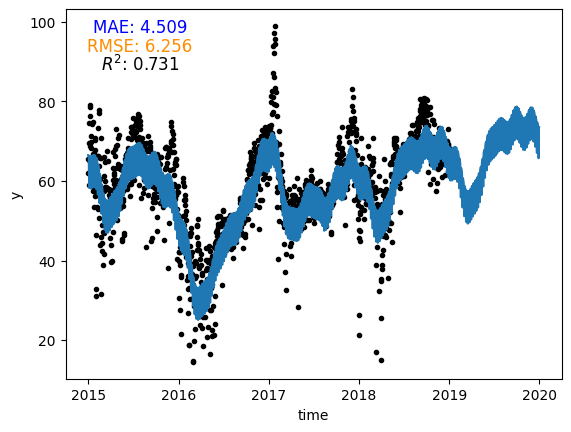

In [32]:
plt.plot(forecast['ds'],forecast['yhat1'])
plt.scatter(forecast['ds'],forecast['y'],s=3**2,c='k')
plt.annotate(f'MAE: {mae:.3f}', xy=(0.15, 0.95), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',c='blue')
plt.annotate(f'RMSE: {rmse:.3f}', xy=(0.15, 0.90), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',c='darkorange')
plt.annotate(fr'$R^2$: {r2:.3f}', xy=(0.15, 0.85), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',c='black')
plt.ylabel('y')
plt.xlabel('time')

In [23]:
df

ds      y
0     2014-12-31  65.41
1     2015-01-01  62.09
2     2015-01-02  69.44
3     2015-01-03  65.22
4     2015-01-04  58.91
...          ...    ...
1457  2018-12-27  72.96
1458  2018-12-28  69.23
1459  2018-12-29  62.62
1460  2018-12-30  64.57
1461  2018-12-31  68.32

[1462 rows x 2 columns]

In [14]:
# Analyze Performance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [24]:
actual = df['y']
predicted = forecast['yhat1'][:len(df)]

In [26]:
import numpy as np

In [28]:
# Calculate and print performance metrics
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
r2 = r2_score(actual, predicted)
print(f'MAE: {mae}, RMSE：{rmse}, r2: {r2}')

MAE: 4.508847145727656, RMSE：6.256065851988379, r2: 0.7310376048878915


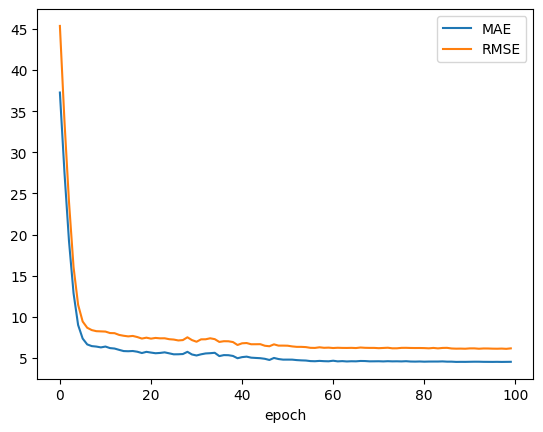

In [22]:
plt.plot(metrics['epoch'],metrics['MAE'],label='MAE')
plt.plot(metrics['epoch'],metrics['RMSE'],label='RMSE')
plt.xlabel('epoch')
plt.legend();


In [ ]:
# LOAD all M0 and M1 result 
Plot the DF 